In [353]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Import Movies Dataset

In [354]:
dfMovies = pd.read_csv('https://raw.githubusercontent.com/droideronline/Business-Analytics-Movielens-Analysis/main/movies.dat',sep="::",names=["MovieID","Title","Genres"],engine='python',encoding='ISO-8859-1')
dfMovies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# Import Ratings Dataset

In [355]:
dfRatings = pd.read_csv("https://raw.githubusercontent.com/droideronline/Business-Analytics-Movielens-Analysis/main/ratings.dat",sep="::",names=["UserID","MovieID","Rating","Timestamp"],engine='python')
dfRatings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# Import Users Dataset

In [356]:
dfUsers = pd.read_csv("https://raw.githubusercontent.com/droideronline/Business-Analytics-Movielens-Analysis/main/users.dat",sep="::",names=["UserID","Gender","Age","Occupation","Zip-code"],engine='python')
dfUsers.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [357]:
dfMovies.shape

(3883, 3)

In [358]:
dfUsers.shape

(6040, 5)

In [359]:
dfRatings.shape

(1000209, 4)

## Create a new dataset (Master Data)

In [360]:
dfMovieRatings = pd.merge(pd.merge(dfRatings,dfMovies),dfUsers)
dfMovieRatings.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


# Dropping rows and columns with missing values

In [361]:
dfMovieRatings.dropna(axis=0, inplace=True)
dfMovieRatings.dropna(axis=1, inplace=True)

In [362]:
dfMovies.info()
dfRatings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


# Master Data after Cleaning

In [363]:
dfMovieRatings.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


# Converting the Timestamp from Unix time (measured in seconds) to a Human-readable Date and Time

In [364]:
dfMovieRatings['Timestamp'] = pd.to_datetime(dfMovieRatings['Timestamp'], unit='s')

In [365]:
dfMovieRatings.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


# Replace the numeric values in the Occupation column with their corresponding occupation names

In [366]:
occupation_mapping = {
    0: 'Other',
    1: 'Academic/Educator',
    2: 'Artist',
    3: 'Clerical/Admin',
    4: 'College/Grad Student',
    5: 'Customer Service',
    6: 'Doctor/Health Care',
    7: 'Executive/Managerial',
    8: 'Farmer',
    9: 'Homemaker',
    10: 'K-12 Student',
    11: 'Lawyer',
    12: 'Programmer',
    13: 'Retired',
    14: 'Sales/Marketing',
    15: 'Scientist',
    16: 'Self-Employed',
    17: 'Technician/Engineer',
    18: 'Tradesman/Craftsman',
    19: 'Unemployed',
    20: 'Writer'
}

# Replace numeric values with occupation names
dfMovieRatings['Occupation'] = dfMovieRatings['Occupation'].map(occupation_mapping)

In [367]:
rts = dfMovieRatings.set_index('Timestamp').sort_index()
rts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000209 entries, 2000-04-25 23:05:32 to 2003-02-28 17:49:50
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1000209 non-null  int64 
 1   MovieID     1000209 non-null  int64 
 2   Rating      1000209 non-null  int64 
 3   Title       1000209 non-null  object
 4   Genres      1000209 non-null  object
 5   Gender      1000209 non-null  object
 6   Age         1000209 non-null  int64 
 7   Occupation  1000209 non-null  object
 8   Zip-code    1000209 non-null  object
dtypes: int64(4), object(5)
memory usage: 76.3+ MB


In [368]:
rts.head(1000)

,UserID,MovieID,Rating,Title,Genres,Gender,Age,Occupation,Zip-code
Timestamp,,,,,,,,,
2000-04-25 23:05:32,6040,858,4,"Godfather, The (1972)",Action|Crime|Drama,M,25,Doctor/Health Care,11106
2000-04-25 23:05:54,6040,593,5,"Silence of the Lambs, The (1991)",Drama|Thriller,M,25,Doctor/Health Care,11106
2000-04-25 23:05:54,6040,2384,4,Babe: Pig in the City (1998),Children's|Comedy,M,25,Doctor/Health Care,11106
2000-04-25 23:06:17,6040,1961,4,Rain Man (1988),Drama,M,25,Doctor/Health Care,11106
2000-04-25 23:06:17,6040,2019,5,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,M,25,Doctor/Health Care,11106
...,...,...,...,...,...,...,...,...,...
2000-04-26 01:51:38,6033,1374,4,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi,M,50,Retired,78232
2000-04-26 01:51:38,6033,1201,4,"Good, The Bad and The Ugly, The (1966)",Action|Western,M,50,Retired,78232
2000-04-26 01:51:50,6036,1243,4,Rosencrantz and Guildenstern Are Dead (1990),Comedy|Drama,F,25,Scientist,32603


In [369]:
rts.iloc[ :, 2]

Timestamp
2000-04-25 23:05:32    4
2000-04-25 23:05:54    5
2000-04-25 23:05:54    4
2000-04-25 23:06:17    4
2000-04-25 23:06:17    5
                      ..
2003-02-28 17:45:38    1
2003-02-28 17:47:23    5
2003-02-28 17:49:08    3
2003-02-28 17:49:08    4
2003-02-28 17:49:50    4
Name: Rating, Length: 1000209, dtype: int64

In [370]:
monthly_ratings = rts.resample('1M')['Rating'].count()
monthly_ratings.head(20)

Timestamp
2000-04-30     11396
2000-05-31     67437
2000-06-30     54486
2000-07-31     90334
2000-08-31    182109
2000-09-30     52421
2000-10-31     42294
2000-11-30    290793
2000-12-31    113487
2001-01-31     18004
2001-02-28      8136
2001-03-31      6083
2001-04-30      5171
2001-05-31      4939
2001-06-30      4981
2001-07-31      4765
2001-08-31      4454
2001-09-30      3077
2001-10-31      2192
2001-11-30      2760
Freq: M, Name: Rating, dtype: int64

# Visualization

## Monthly Ratings Over Time

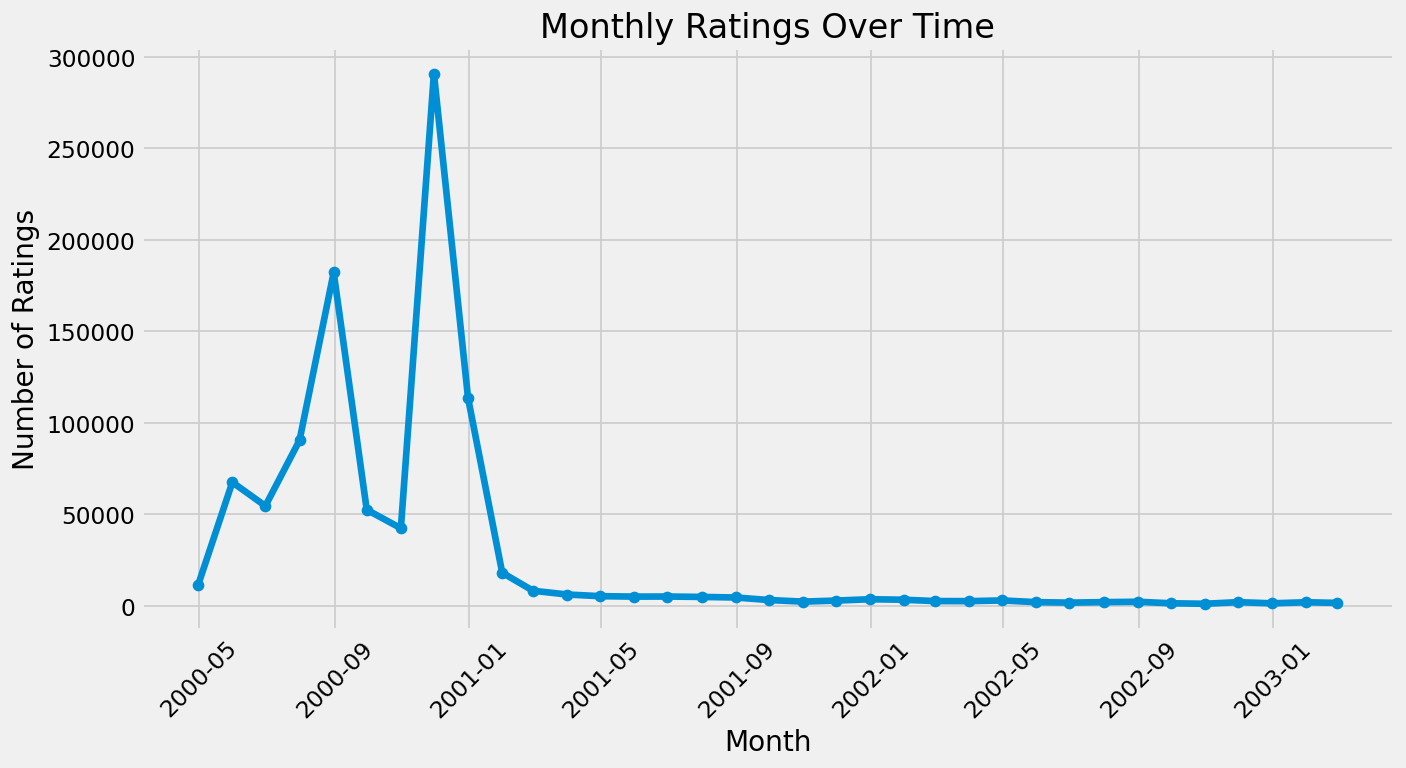

In [371]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratings.index, monthly_ratings.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Monthly Ratings Over Time')
plt.xticks(rotation=45)
plt.show()

## Monthly Ratings Count - Box Plot

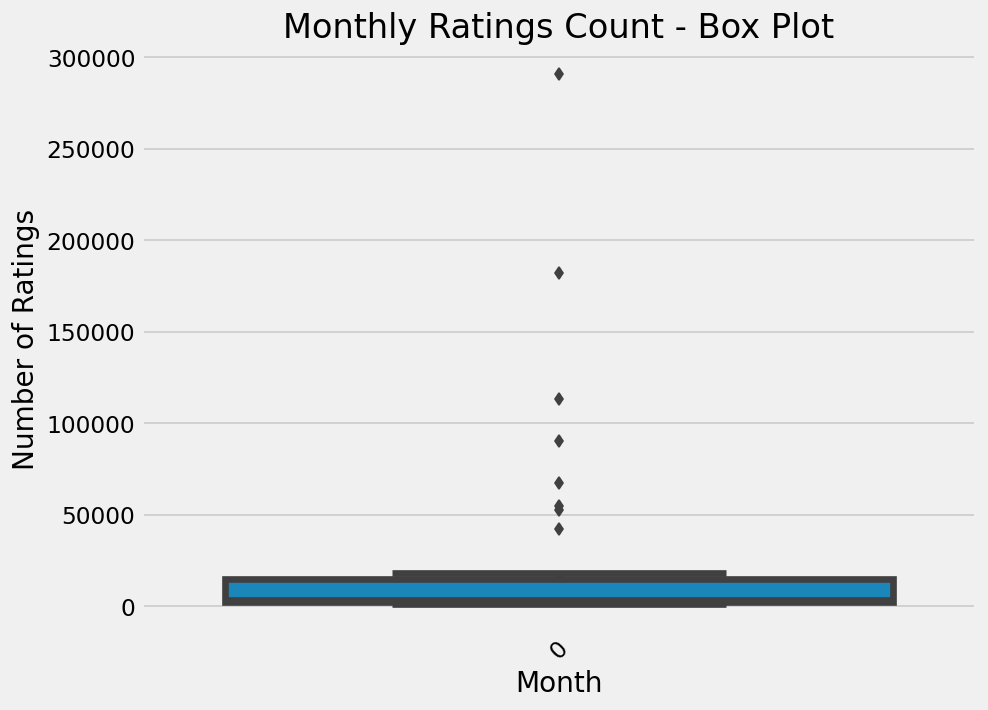

In [372]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=monthly_ratings)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Monthly Ratings Count - Box Plot')
plt.xticks(rotation=45)
plt.show()

## Monthly Ratings with Rolling Mean and Standard Deviation

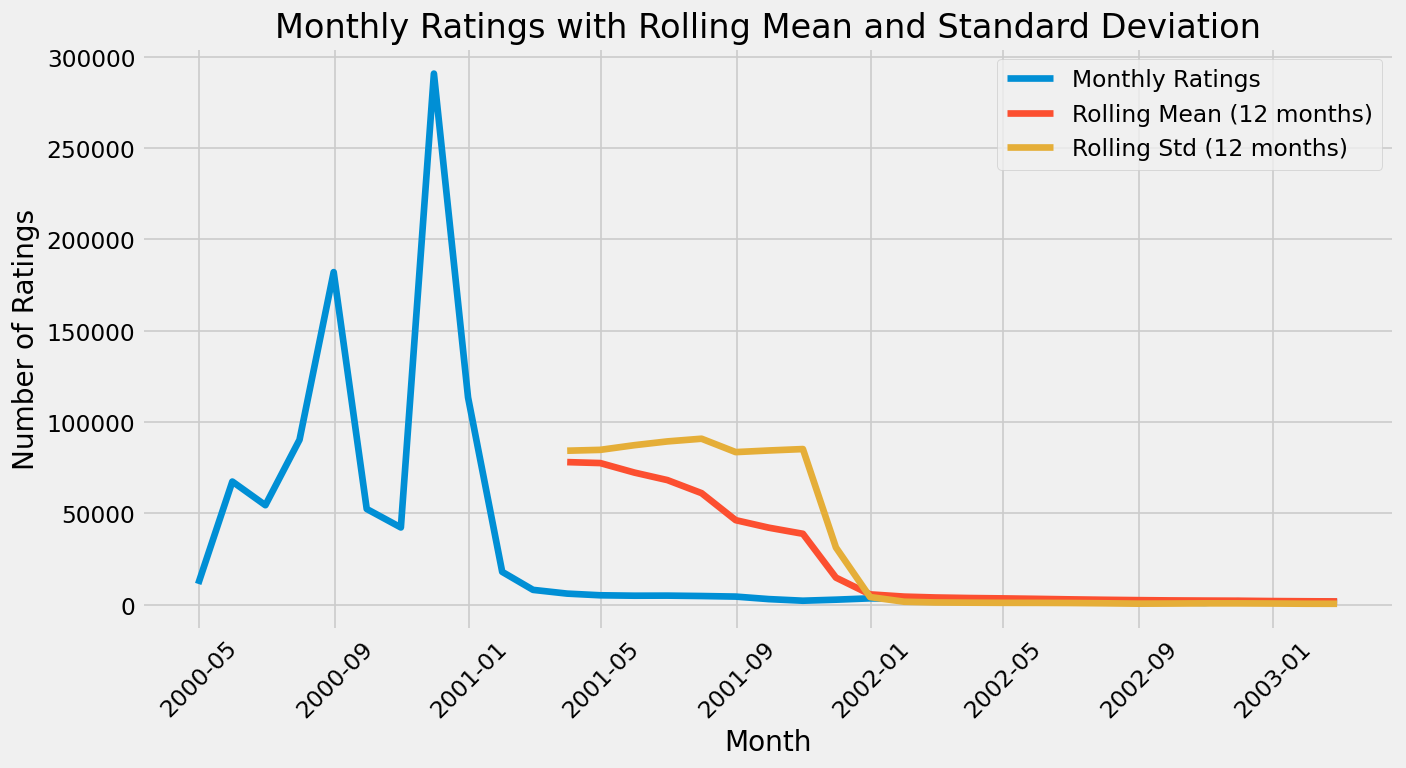

In [373]:
plt.figure(figsize=(12, 6))
rolling_mean = monthly_ratings.rolling(window=12).mean()
rolling_std = monthly_ratings.rolling(window=12).std()
plt.plot(monthly_ratings.index, monthly_ratings.values, label='Monthly Ratings')
plt.plot(monthly_ratings.index, rolling_mean, label='Rolling Mean (12 months)')
plt.plot(monthly_ratings.index, rolling_std, label='Rolling Std (12 months)')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Monthly Ratings with Rolling Mean and Standard Deviation')
plt.xticks(rotation=45)
plt.legend()
plt.show()

##Monthly Ratings Over Time by Gender

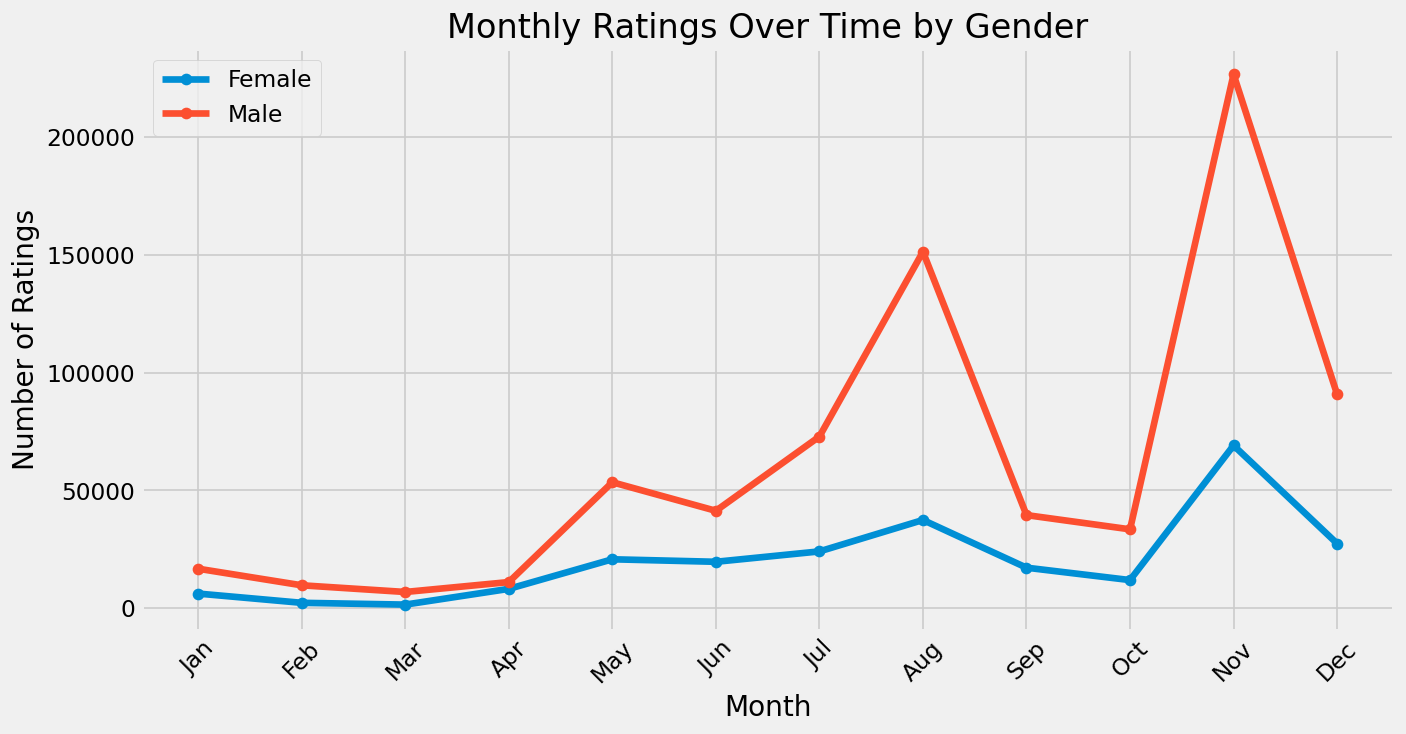

In [374]:
# Group ratings by gender and resample to monthly frequency
monthly_ratings_gender = rts.groupby([rts.index.month, 'Gender'])['Rating'].count().unstack()

plt.figure(figsize=(12, 6))
plt.plot(monthly_ratings_gender.index, monthly_ratings_gender['F'], marker='o', label='Female')
plt.plot(monthly_ratings_gender.index, monthly_ratings_gender['M'], marker='o', label='Male')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Monthly Ratings Over Time by Gender')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend()
plt.show()

## Monthly Ratings Over Time by Age

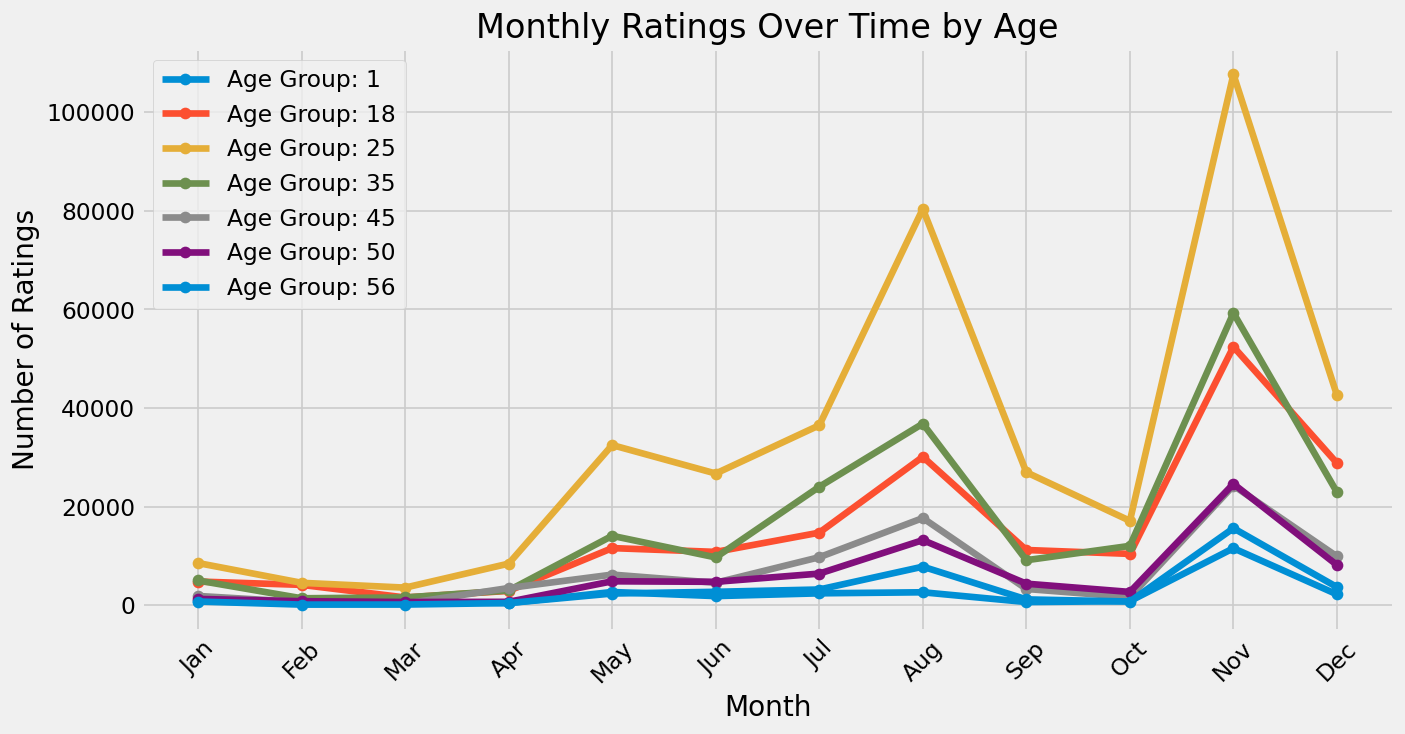

In [375]:
# Group ratings by age and resample to monthly frequency
monthly_ratings_age = rts.groupby([rts.index.month, 'Age'])['Rating'].count().unstack()

plt.figure(figsize=(12, 6))
for age_group in monthly_ratings_age.columns:
    plt.plot(monthly_ratings_age.index, monthly_ratings_age[age_group], marker='o', label=f'Age Group: {age_group}')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Monthly Ratings Over Time by Age')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend()
plt.show()


## Monthly Ratings Over Time for Top 10 Movies (Rating 5)

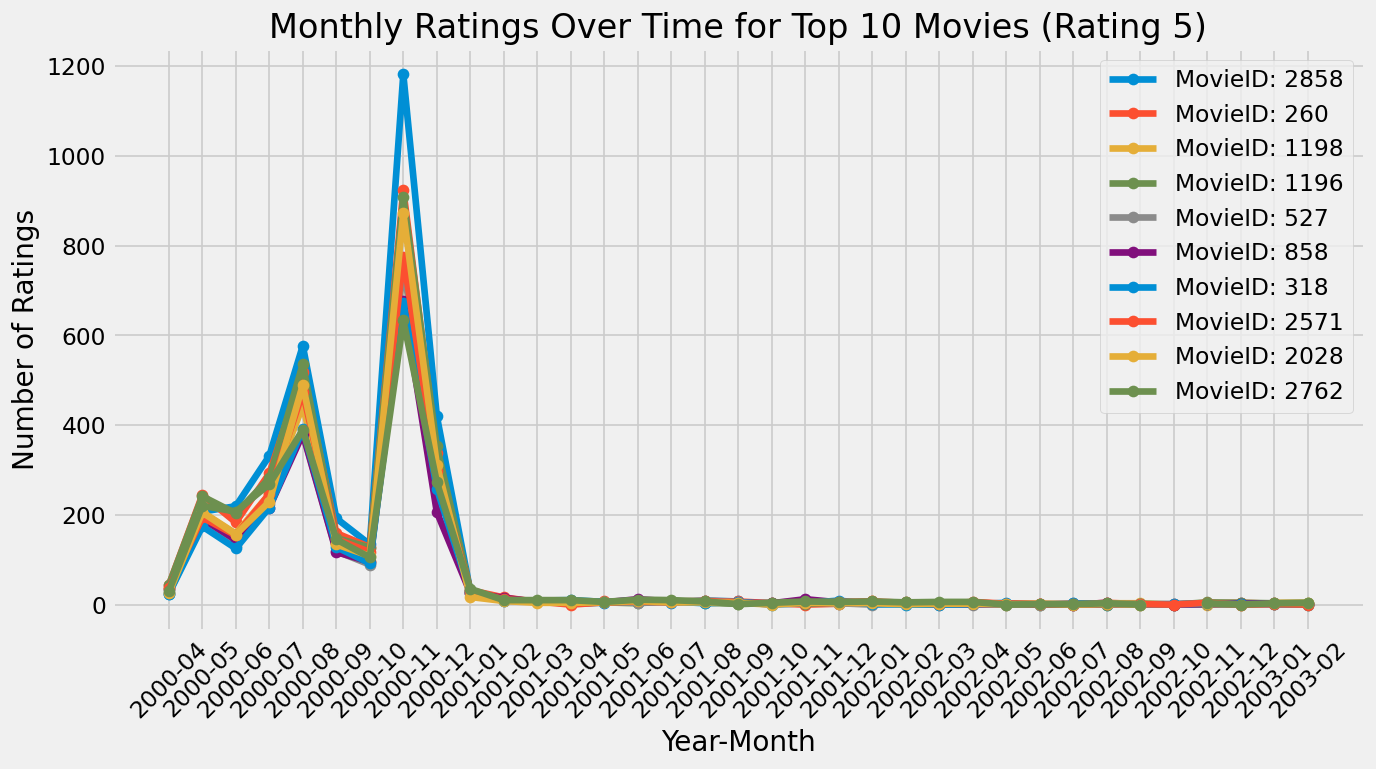

In [376]:
top_ratings = rts[rts['Rating'] == 5]

top_movies = top_ratings.groupby('MovieID')['Rating'].count().nlargest(10).index

top_movies_data = rts[rts['MovieID'].isin(top_movies)].copy()

top_movies_data['Year-Month'] = top_movies_data.index.strftime('%Y-%m')

monthly_counts = top_movies_data.groupby(['Year-Month', 'MovieID'])['Rating'].count().unstack()

plt.figure(figsize=(12, 6))
for movie in top_movies:
    plt.plot(monthly_counts.index, monthly_counts[movie], marker='o', label=f'MovieID: {movie}')
plt.xlabel('Year-Month')
plt.ylabel('Number of Ratings')
plt.title('Monthly Ratings Over Time for Top 10 Movies (Rating 5)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Monthly Ratings Over Time for Occupations

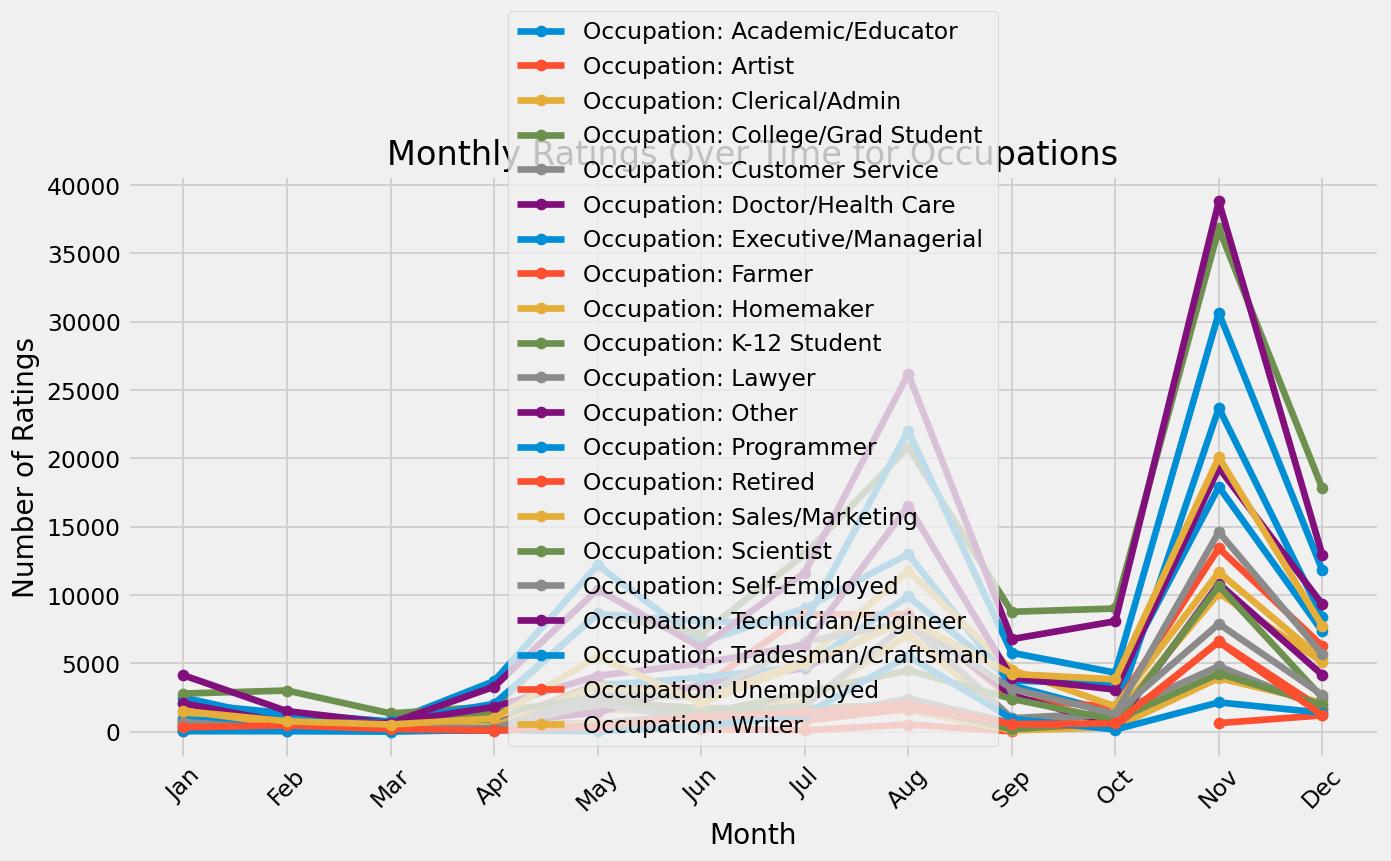

In [377]:
monthly_occupations = rts.groupby([rts.index.month, 'Occupation'])['Rating'].count().unstack()

plt.figure(figsize=(12, 6))
for occupation in monthly_occupations.columns:
    plt.plot(monthly_occupations.index, monthly_occupations[occupation], marker='o', label=f'Occupation: {occupation}')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Monthly Ratings Over Time for Occupations')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend()
plt.show()

## Number of Ratings Over Time

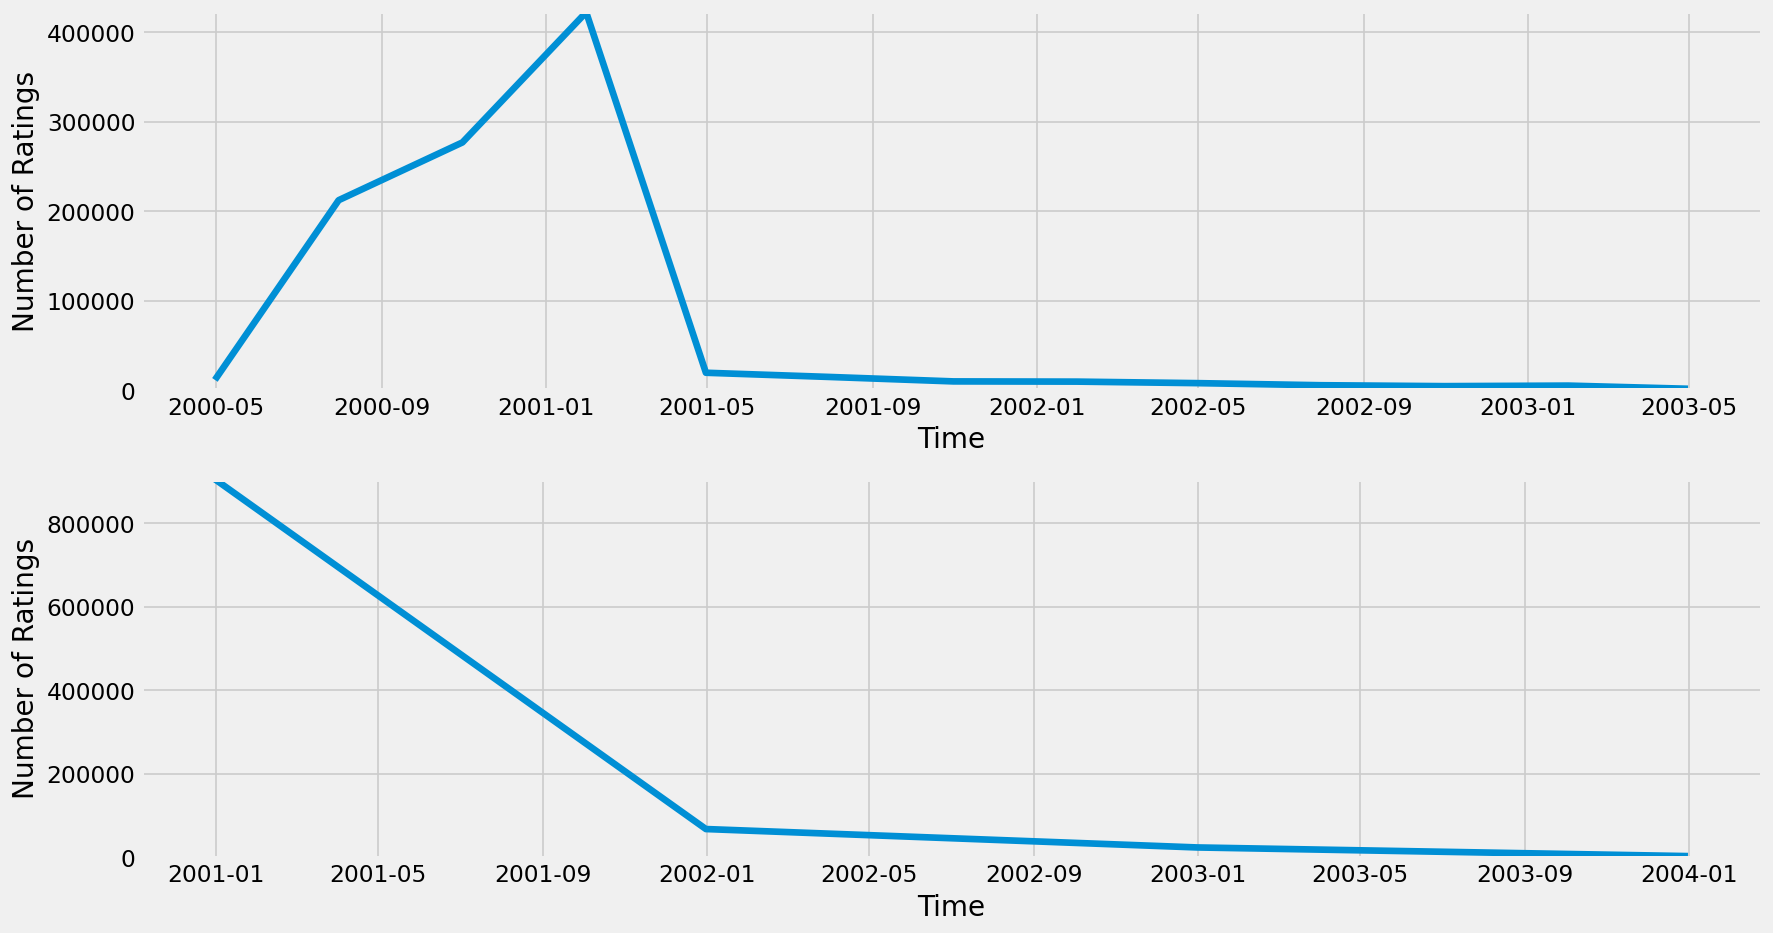

In [378]:
# Create shorter and longer time series
shorter_ts = rts.resample('3M').size()
longer_ts = rts.resample('1Y').size()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

# shorter time series
axes[0].plot(shorter_ts.index, shorter_ts.values)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Number of Ratings')
axes[0].set_ylim(0, shorter_ts.max() + 1000)

# longer time series
axes[1].plot(longer_ts.index, longer_ts.values)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number of Ratings')
axes[1].set_ylim(0, longer_ts.max() + 1000)

plt.tight_layout()

plt.show()

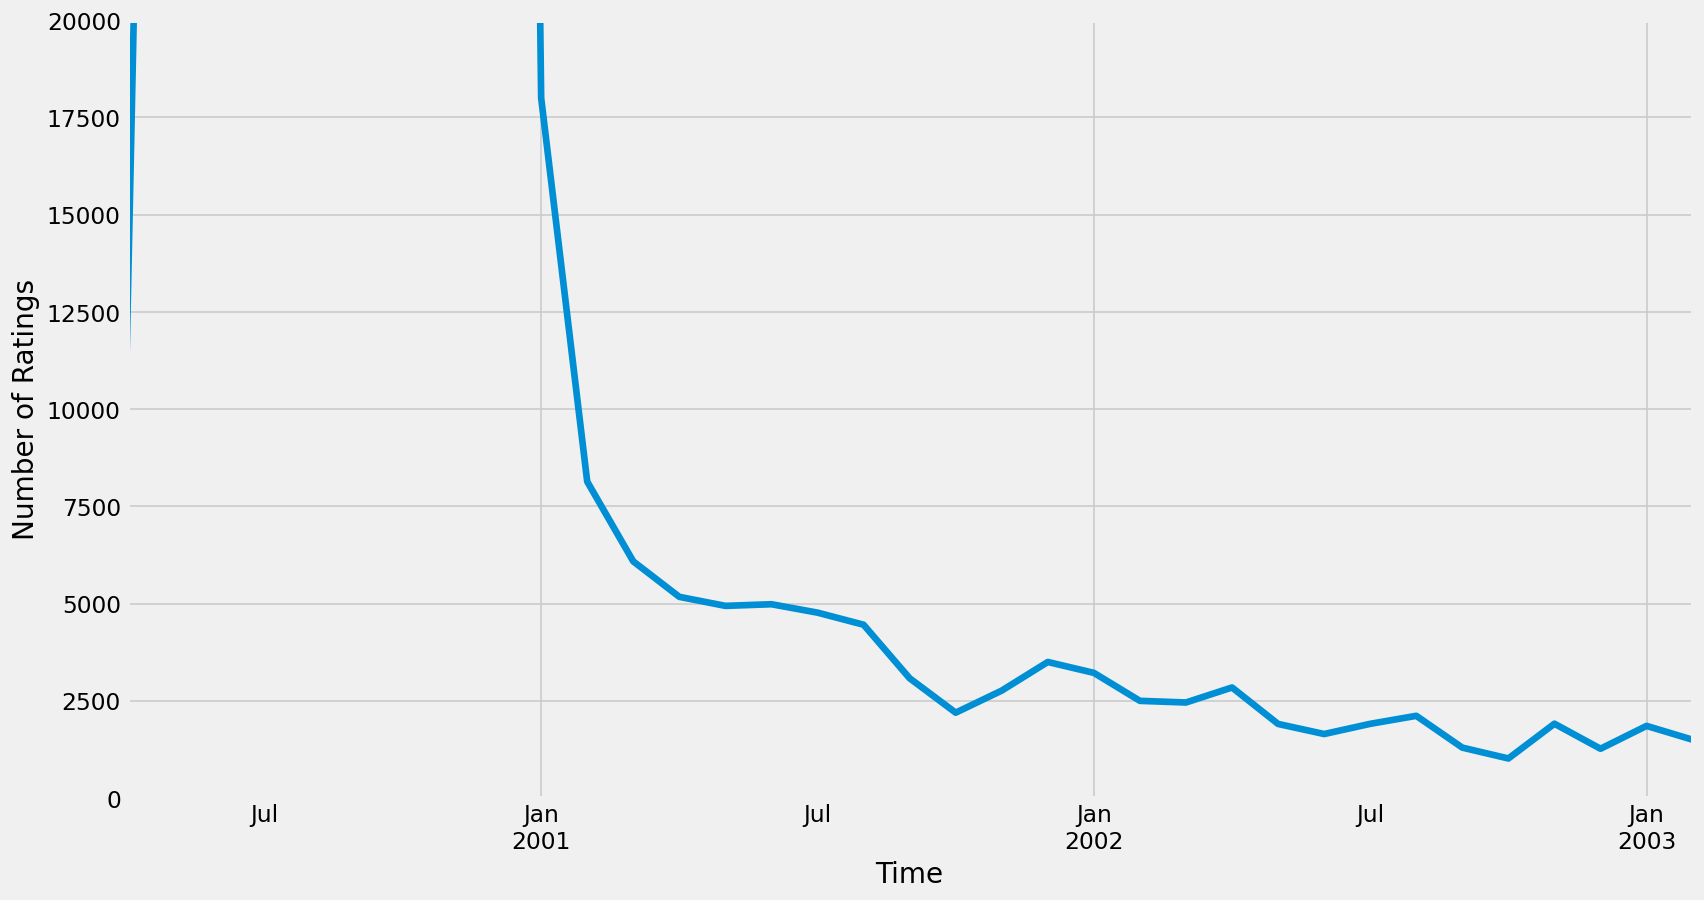

In [379]:
ax = monthly_ratings.plot(figsize=(15, 8))
ax.set_xlabel("Time")
ax.set_ylabel("Number of Ratings")
ax.set_ylim(0, 20000)
plt.show()

In [380]:
rts.columns

Index(['UserID', 'MovieID', 'Rating', 'Title', 'Genres', 'Gender', 'Age',
       'Occupation', 'Zip-code'],
      dtype='object')

# Arima

In [381]:
rst1 = pd.merge(pd.merge(dfRatings,dfMovies),dfUsers)

In [382]:
rst1

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
1000204,4211,3791,2,965319075,Footloose (1984),Drama,M,45,5,77662
1000205,4211,3806,3,965319138,MacKenna's Gold (1969),Western,M,45,5,77662
1000206,4211,3840,4,965319197,Pumpkinhead (1988),Horror,M,45,5,77662
1000207,4211,3766,2,965319138,Missing in Action (1984),Action|War,M,45,5,77662


In [383]:
rst1['Timestamp'] = pd.to_datetime(rst1['Timestamp'], format='%d-%m-%Y %H:%M:%S', errors='coerce').astype(int) / 10**9

In [384]:
rts1 = dfMovieRatings.iloc[ :, 2:4]


In [385]:
rts1

,Rating,Timestamp
0,5,2000-12-31 22:12:40
1,3,2000-12-31 22:35:09
2,3,2000-12-31 22:32:48
3,4,2000-12-31 22:04:35
4,5,2001-01-06 23:38:11
...,...,...
1000204,2,2000-08-03 16:11:15
1000205,3,2000-08-03 16:12:18
1000206,4,2000-08-03 16:13:17
1000207,2,2000-08-03 16:12:18


In [386]:
rts2 = rts1[rts1['Timestamp'] > '2001-01-01']

In [387]:
rts2

,Rating,Timestamp
4,5,2001-01-06 23:38:11
10,5,2001-01-06 23:37:48
16,3,2001-01-06 23:37:48
23,5,2001-01-06 23:36:35
25,5,2001-01-06 23:39:11
...,...,...
998879,5,2001-01-16 10:36:45
998880,5,2001-01-16 10:30:03
998881,3,2001-01-16 10:33:58
998884,5,2001-01-16 10:38:06


In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
rts2['Timestamp'] = pd.to_datetime(rts2['Timestamp'], unit='s')
data_agg = rts2.resample('D', on='Timestamp').mean()
data_agg

<ipython-input-388-0fb4c47d2664>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rts2['Timestamp'] = pd.to_datetime(rts2['Timestamp'], unit='s')


,Rating
Timestamp,
2001-01-01,3.668770
2001-01-02,3.464012
2001-01-03,3.724613
2001-01-04,3.439834
2001-01-05,3.412595
...,...
2003-02-24,4.236842
2003-02-25,3.093407
2003-02-26,3.600000


In [389]:
data_agg.columns


Index(['Rating'], dtype='object')

# Stationarity check

In [390]:
#Stationarity check
result = adfuller(data_agg['Rating'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])



ADF Statistic: -5.273279073367214
p-value: 6.218427854107895e-06


i)The ADF statistic value of -5.273279073367214 is a test statistic that helps determine the stationarity of the 'Rating' data. The more negative the ADF statistic, the stronger the evidence for rejecting the null hypothesis of non-stationarity.




ii)The p-value of 6.218427854107895e-06 is the probability of observing a test statistic as extreme as the one obtained, assuming the null hypothesis of non-stationarity is true. In this case, the extremely small p-value suggests strong evidence against the null hypothesis. Typically, if the p-value is less than a chosen significance level (e.g., 0.05), the null hypothesis is rejected in favor of the alternative hypothesis, indicating that the data is stationary.


In [391]:
result

(-5.273279073367214,
 6.218427854107895e-06,
 16,
 772,
 {'1%': -3.4388489336836003,
  '5%': -2.865291103159288,
  '10%': -2.568767459327767},
 625.7112110162645)

In [392]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [393]:
plt.style.use('fivethirtyeight')

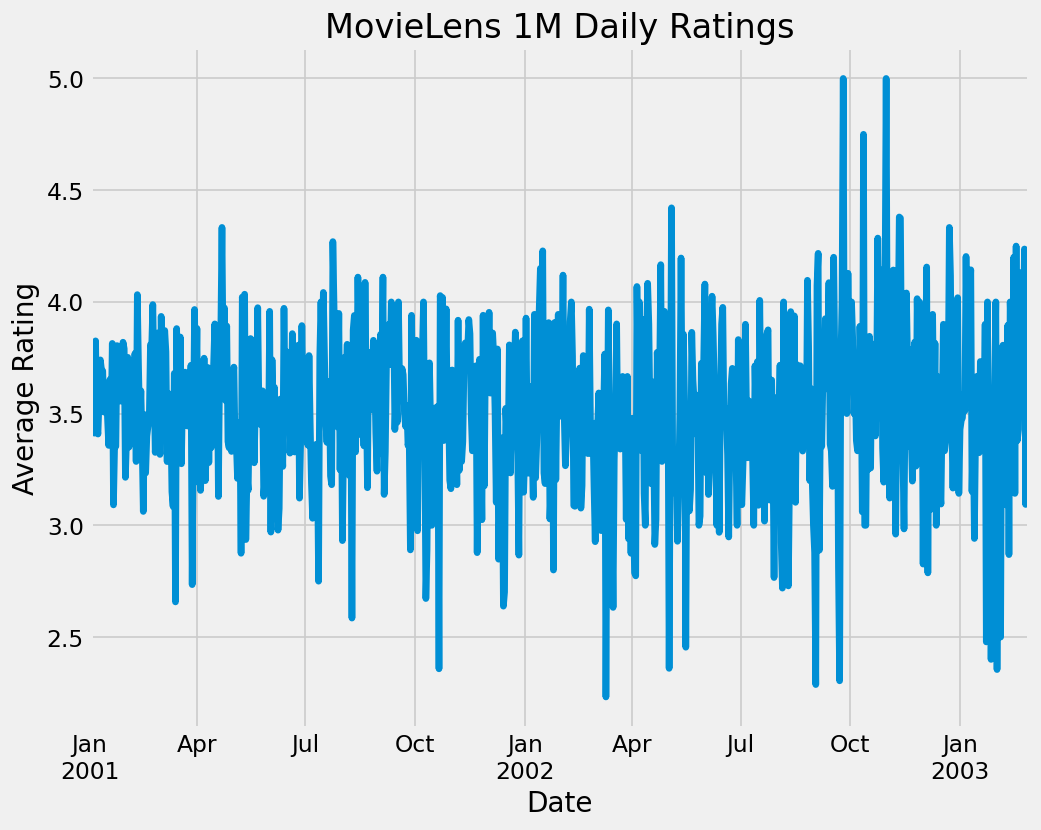

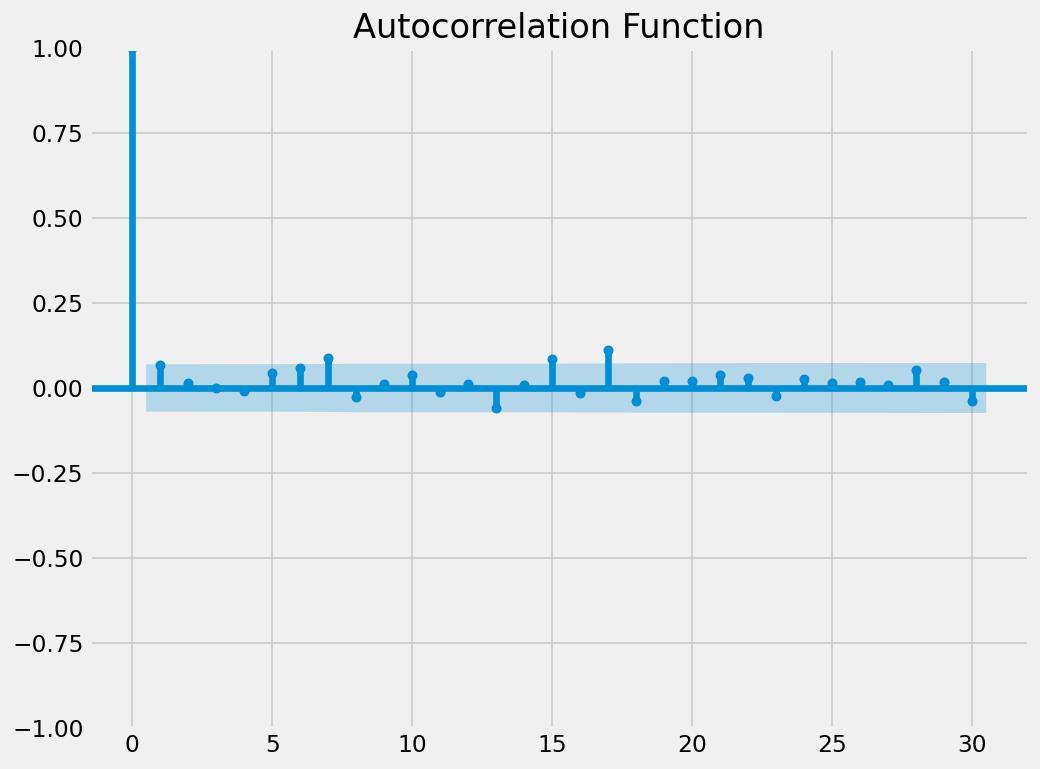

In [394]:
data_agg['Rating'].plot()
plt.title('MovieLens 1M Daily Ratings')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()

plot_acf(data_agg['Rating'], lags=30)
plt.title('Autocorrelation Function')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


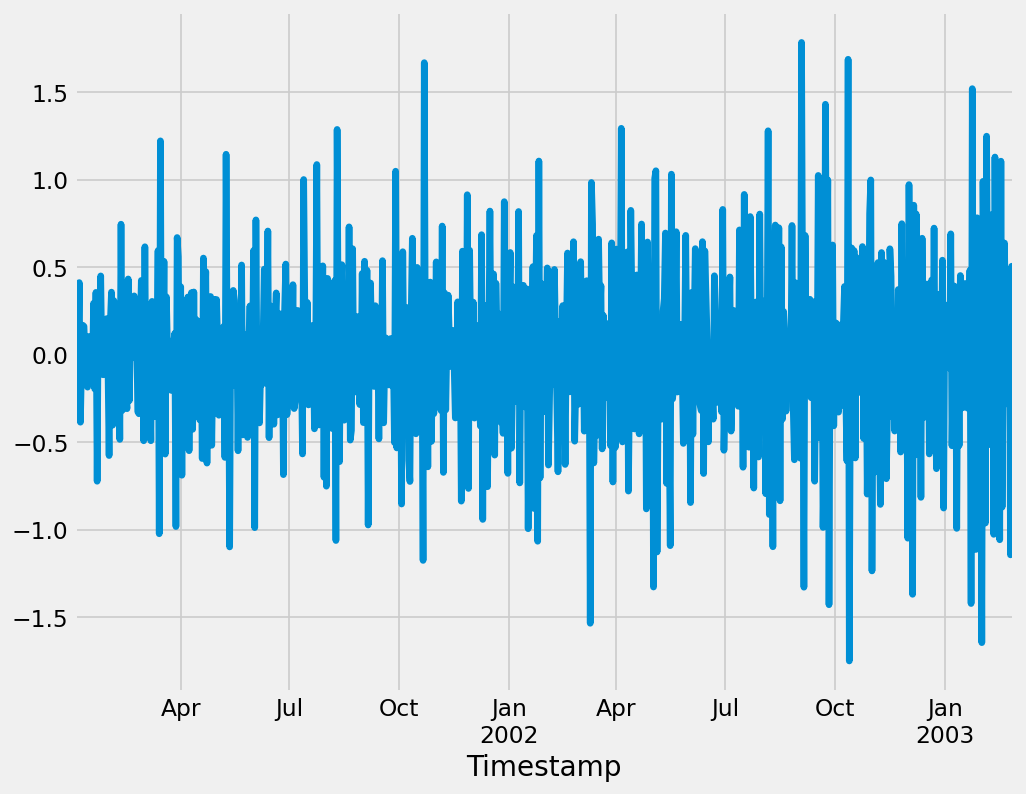

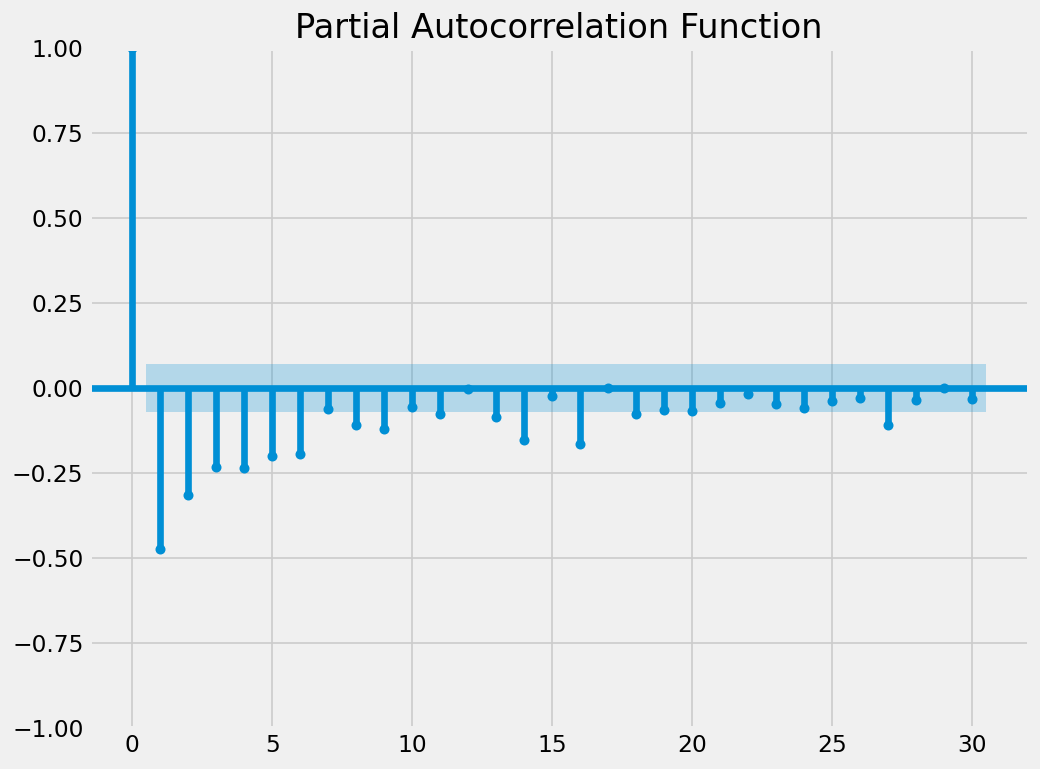

In [395]:
# 1st Differencing
data_agg['rating_diff'] = data_agg['Rating'].diff()
data_agg.dropna(inplace=True)
data_agg['rating_diff'].plot()
plot_pacf(data_agg['rating_diff'], lags=30)
plt.title('Partial Autocorrelation Function')
plt.show()

In [396]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'data_agg' is your differenced time series data
adf_result = adfuller(data_agg['rating_diff'])

adf_statistic = adf_result[0]
p_value = adf_result[1]

print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -10.870631759750568
p-value: 1.3713875516150324e-19


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


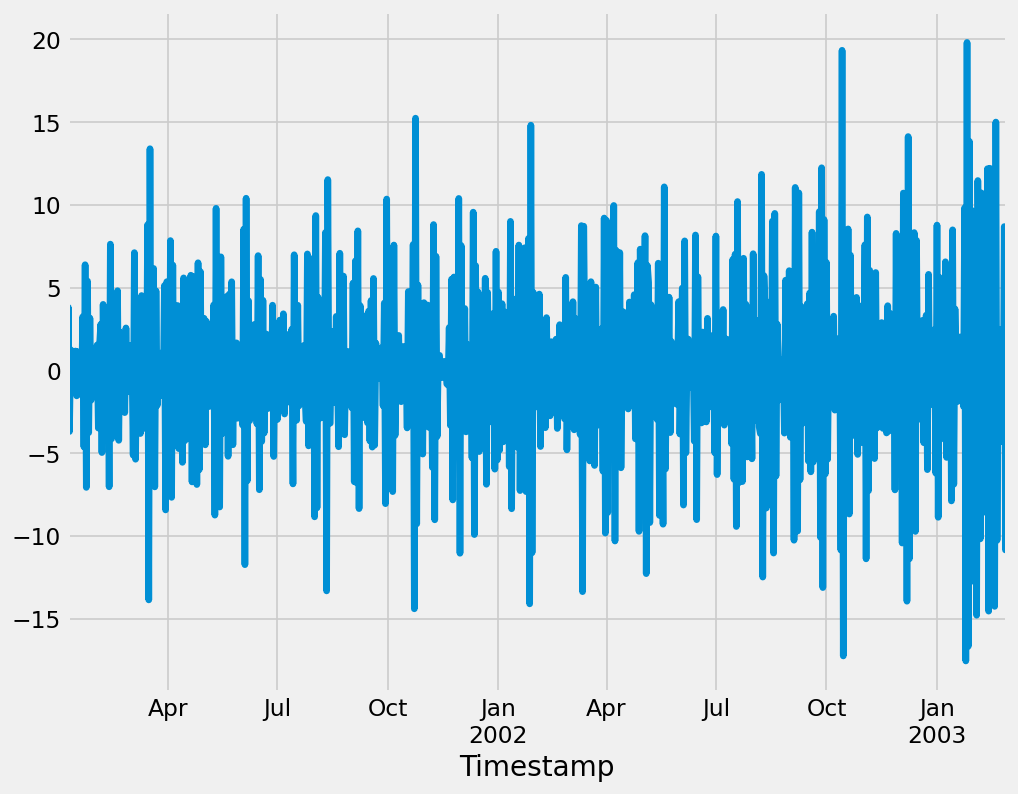

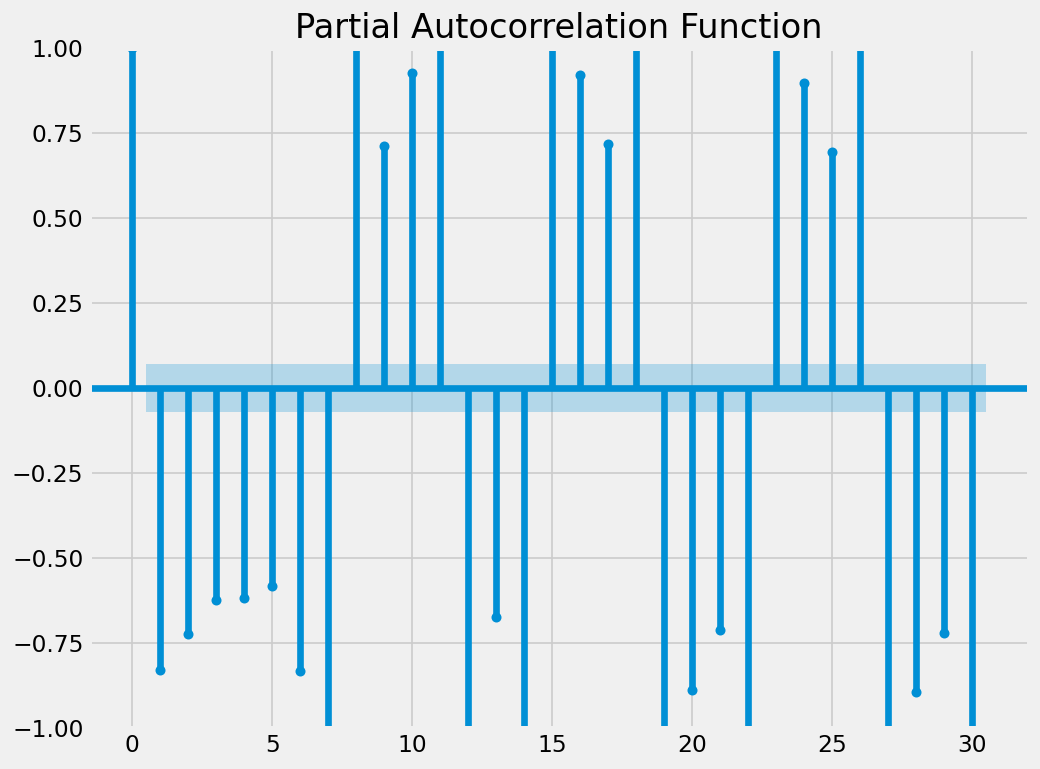

In [397]:
#Differencing
data_agg['rating_diff'] = data_agg['Rating'].diff().diff().diff().diff().diff()
data_agg.dropna(inplace=True)
data_agg['rating_diff'].plot()
plot_pacf(data_agg['rating_diff'], lags=30)
plt.title('Partial Autocorrelation Function')
plt.show()

In [398]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'data_agg' is your differenced time series data
adf_result = adfuller(data_agg['rating_diff'])

adf_statistic = adf_result[0]
p_value = adf_result[1]

print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -18.573929497774557
p-value: 2.0812010912180035e-30


 The ADF statistic of -21.47324086797478 and the very small p-value of 0 suggest strong evidence to reject the null hypothesis of non-stationarity. This indicates that the differenced time series data in the 'rating_diff' column of 'data_agg' is likely stationary.

In [399]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [400]:
from statsmodels.tsa.stattools import kpss

# Perform KPSS test on the resampled time series data
kpss_result = kpss(data_agg['rating_diff'])

# Extract the KPSS test statistics and p-value
kpss_statistic = kpss_result[0]
p_value = kpss_result[1]
critical_values = kpss_result[3]

# Print the KPSS test statistics, p-value, and critical values
print("KPSS Statistic:", kpss_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

KPSS Statistic: 0.057439712252648926
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [401]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the resampled time series data
adf_result = adfuller(data_agg['rating_diff'])

# Extract the ADF test statistics and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Print the ADF test statistics, p-value, and critical values
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")


ADF Statistic: -18.573929497774557
p-value: 2.0812010912180035e-30
Critical Values:
   1%: -3.4389722010249386
   5%: -2.8653454308425705
   10%: -2.5687964010457227


In [402]:
from statsmodels.tsa.stattools import zivot_andrews

# Perform the Zivot and Andrews test
result = zivot_andrews(data_agg['rating_diff'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print("Test Statistic:", test_statistic)
print("p-value:", p_value)

Test Statistic: -18.55726448177029
p-value: 1e-05


Having a result of 0 suggests that the mean, variance, and autocorrelation of the 'rating_diff' data are already constant over time. Thus, it is already suitable for modeling using stationary time series models like ARMA (Autoregressive Moving Average) or ARIMA (Autoregressive Integrated Moving Average).

# IDENTIFY PATTERNS

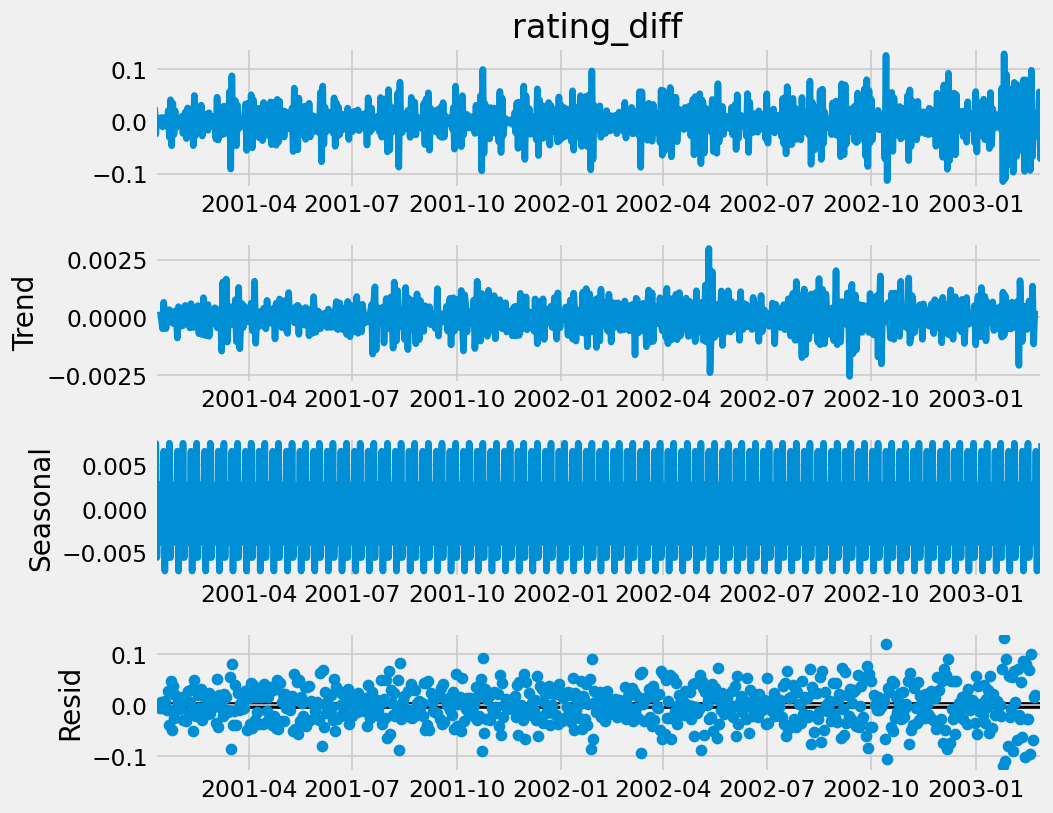

In [403]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data_agg['rating_diff'], model='additive', period=12)
result.plot()
plt.show()


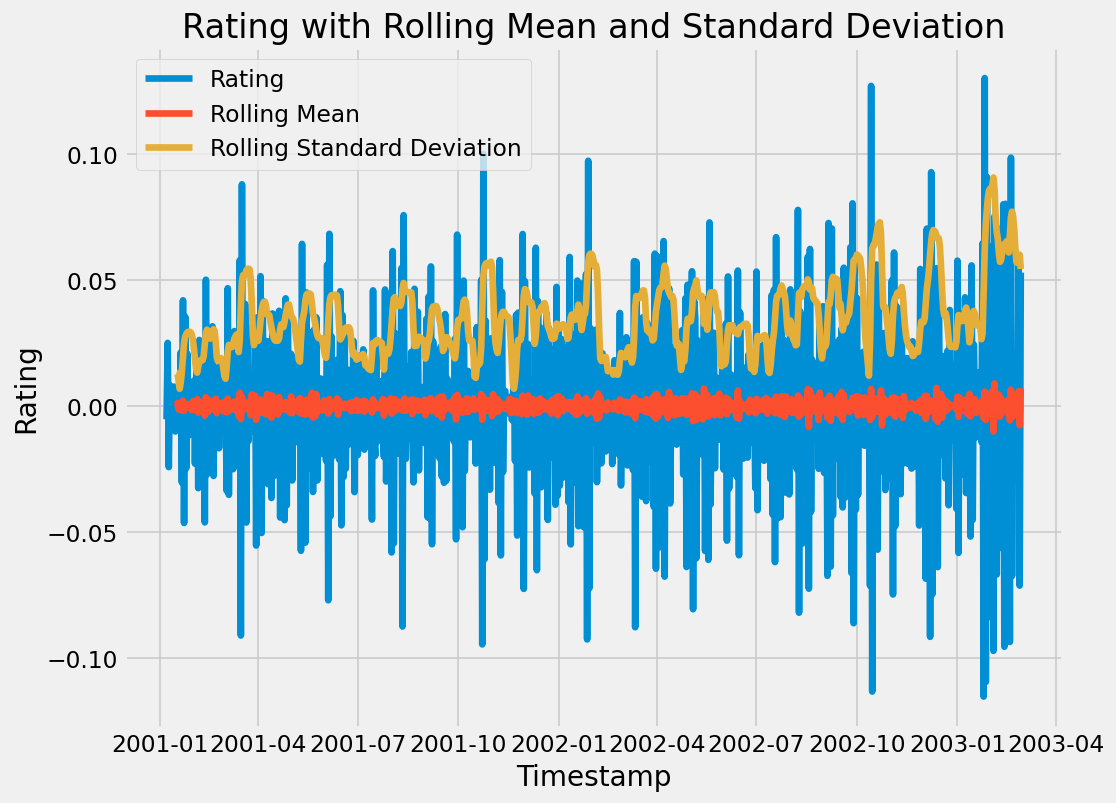

In [404]:
rolling_mean = data_agg['rating_diff'].rolling(window=10).mean()
rolling_std = data_agg['rating_diff'].rolling(window=10).std()
data_agg = data_agg.reset_index().rename(columns={'index': 'Timestamp'})

plt.plot(data_agg['Timestamp'], data_agg['rating_diff'], label='Rating')
plt.plot(data_agg['Timestamp'], rolling_mean, label='Rolling Mean')
plt.plot(data_agg['Timestamp'], rolling_std, label='Rolling Standard Deviation')
plt.xlabel('Timestamp')
plt.ylabel('Rating')
plt.title('Rating with Rolling Mean and Standard Deviation')
plt.legend()
plt.show()


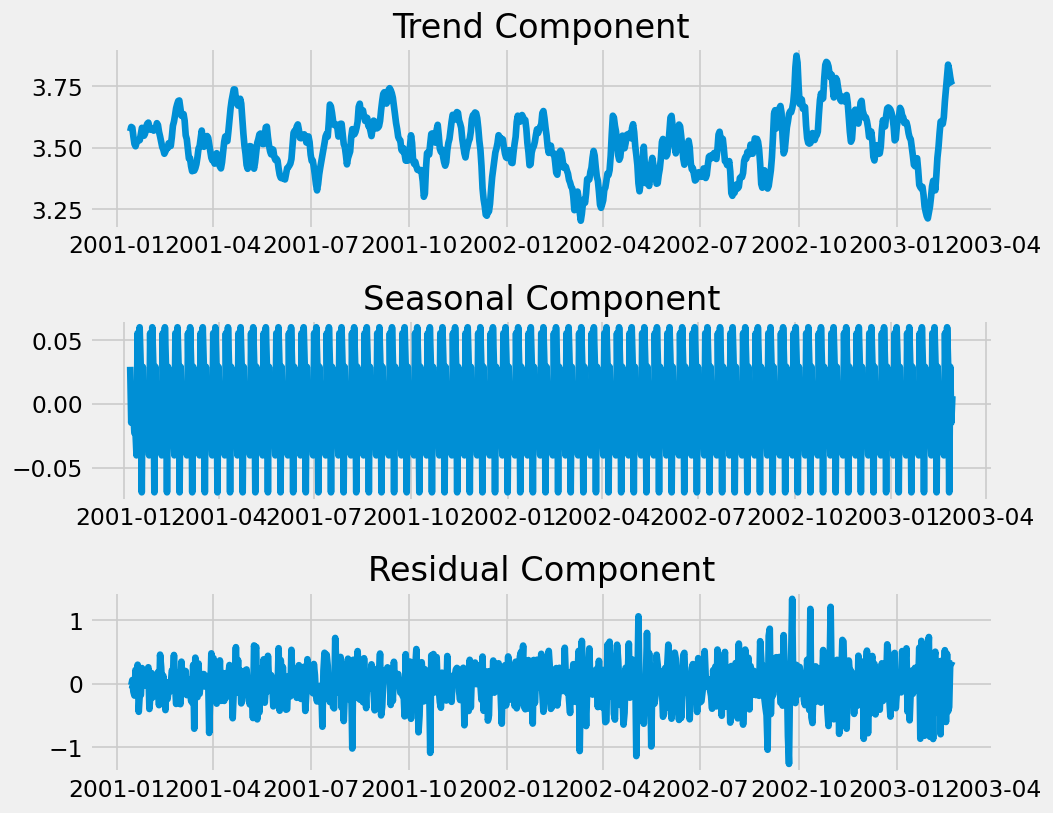

In [405]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose( data_agg['Rating'], model='additive', period=12)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

plt.subplot(3, 1, 1)
plt.plot(data_agg['Timestamp'], trend)
plt.title('Trend Component')

plt.subplot(3, 1, 2)
plt.plot(data_agg['Timestamp'], seasonal)
plt.title('Seasonal Component')

plt.subplot(3, 1, 3)
plt.plot(data_agg['Timestamp'], residual)
plt.title('Residual Component')

plt.tight_layout()
plt.show()


# ARIMA

# AR Term(p)

In [406]:
rts2['Timestamp'] = pd.to_datetime(rts2['Timestamp'], unit='s')
data_agg = rts2.resample('D', on='Timestamp').mean()
data_agg

<ipython-input-406-759457829043>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rts2['Timestamp'] = pd.to_datetime(rts2['Timestamp'], unit='s')


,Rating
Timestamp,
2001-01-01,3.668770
2001-01-02,3.464012
2001-01-03,3.724613
2001-01-04,3.439834
2001-01-05,3.412595
...,...
2003-02-24,4.236842
2003-02-25,3.093407
2003-02-26,3.600000


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


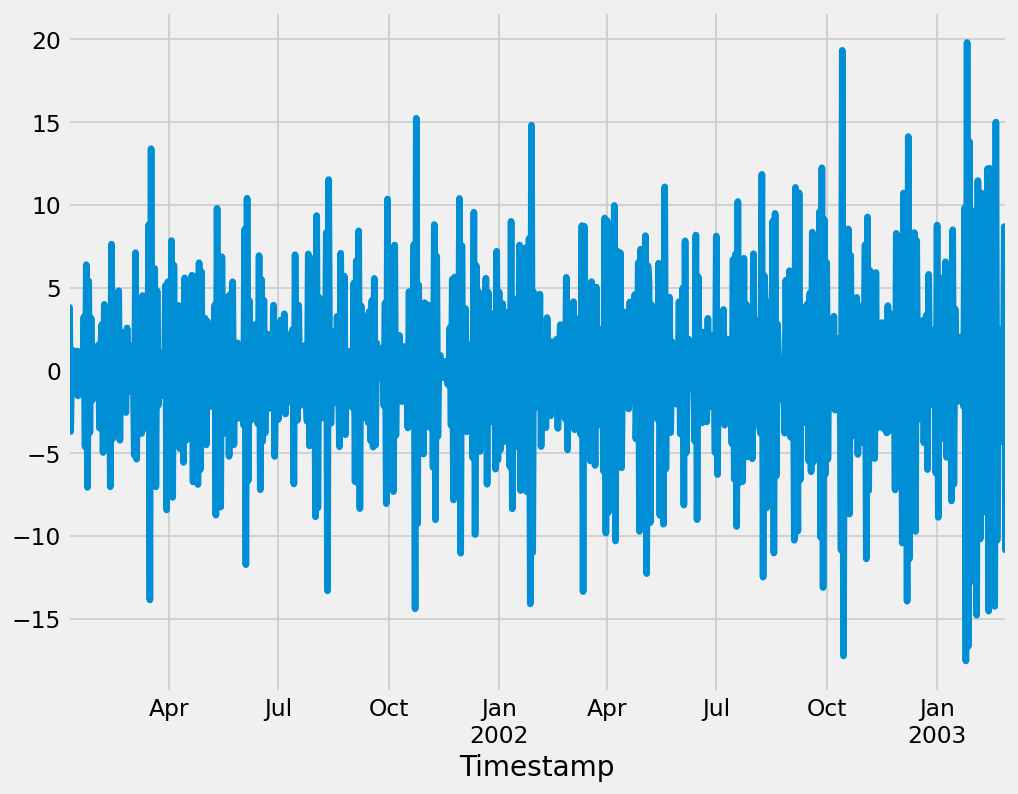

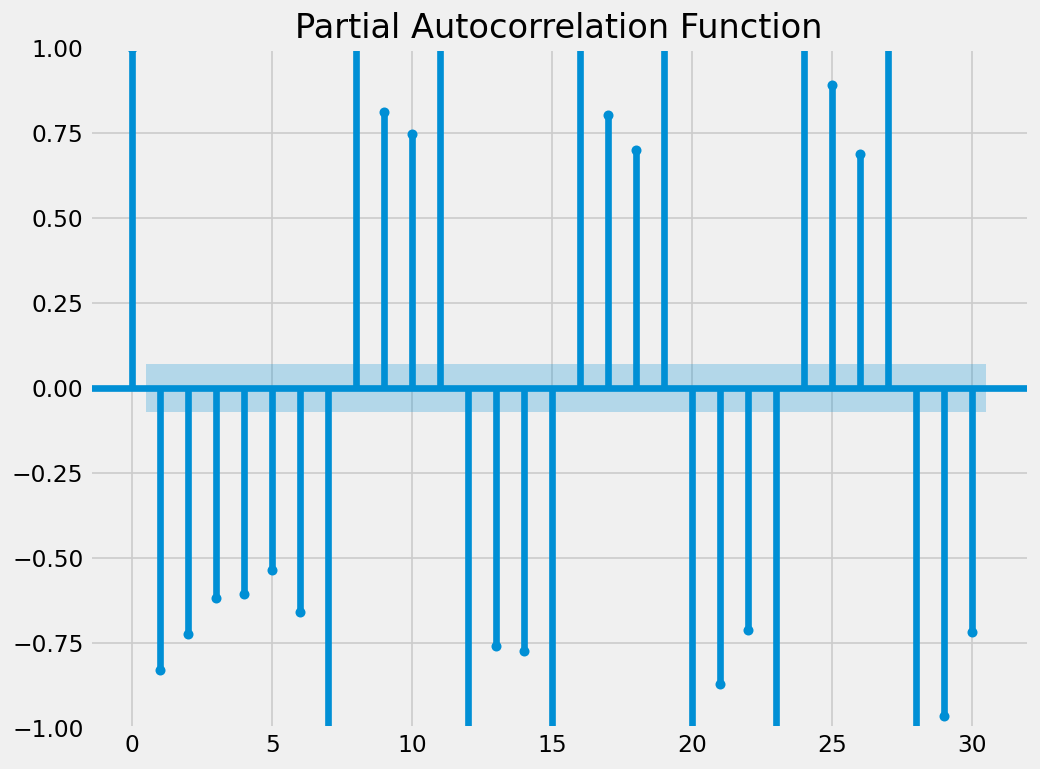

In [407]:
data_agg['rating_diff'] = data_agg['Rating'].diff().diff().diff().diff().diff()
data_agg.dropna(inplace=True)
data_agg['rating_diff'].plot()
plot_pacf(data_agg['rating_diff'], lags=30)
plt.title('Partial Autocorrelation Function')
plt.show()

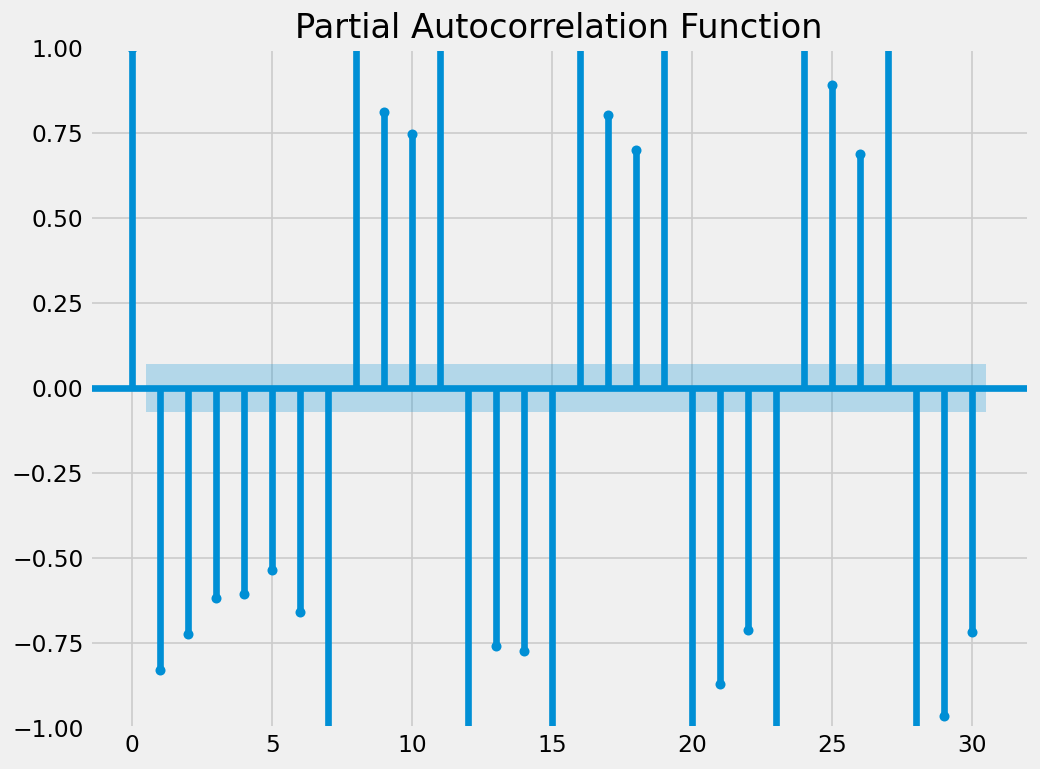

In [408]:
plot_pacf(data_agg['rating_diff'], lags=30)
plt.title('Partial Autocorrelation Function')
plt.show()

Take P value as 1

# MA term (q)

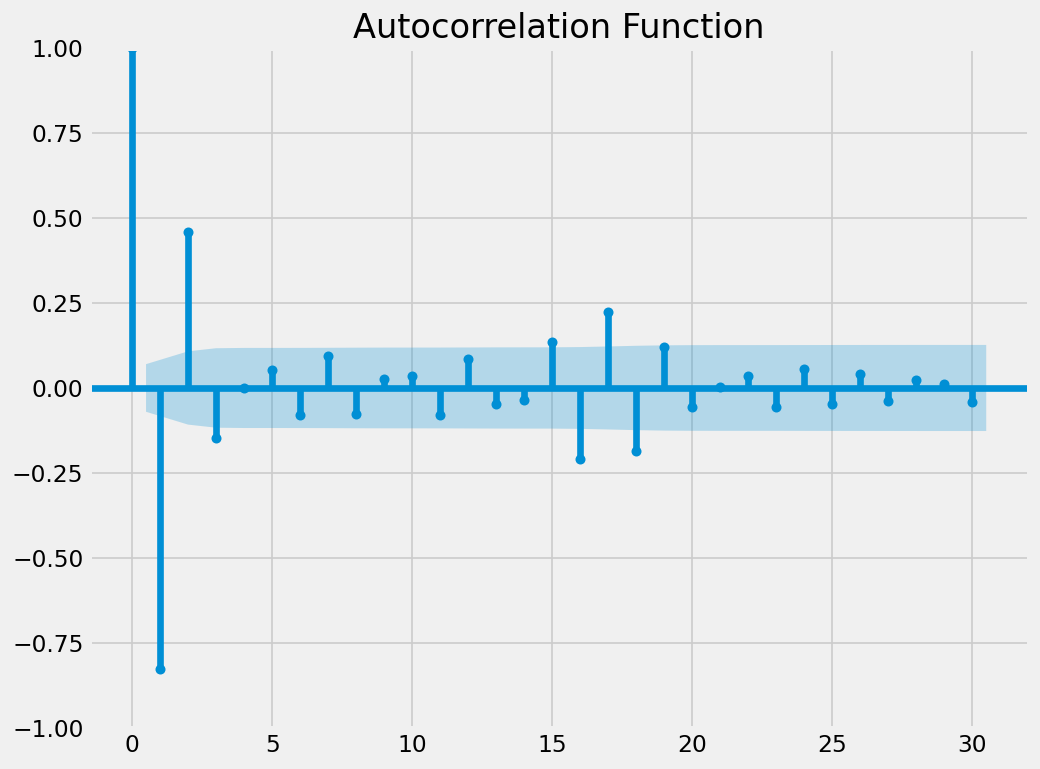

In [409]:
plot_acf(data_agg['rating_diff'], lags=30)
plt.title('Autocorrelation Function')
plt.show()

Take q as 1

# ARIMA model

In [410]:
train_size = int(len(data_agg) * 0.8)
train_data = data_agg['rating_diff'][:train_size]
test_data = data_agg['rating_diff'][train_size:]

In [411]:
order = (1, 1, 1)#(p,d,q)  
model = ARIMA(train_data, order=order)
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            rating_diff   No. Observations:                  627
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1551.206
Date:                Wed, 07 Jun 2023   AIC                           3108.413
Time:                        04:59:54   BIC                           3121.731
Sample:                    01-06-2001   HQIC                          3113.587
                         - 09-24-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8070      0.023    -34.848      0.000      -0.852      -0.762
ma.L1         -0.9997      0.861     -1.161      0.246      -2.688       0.688
sigma2         8.2026      7.100      1.155      0.2

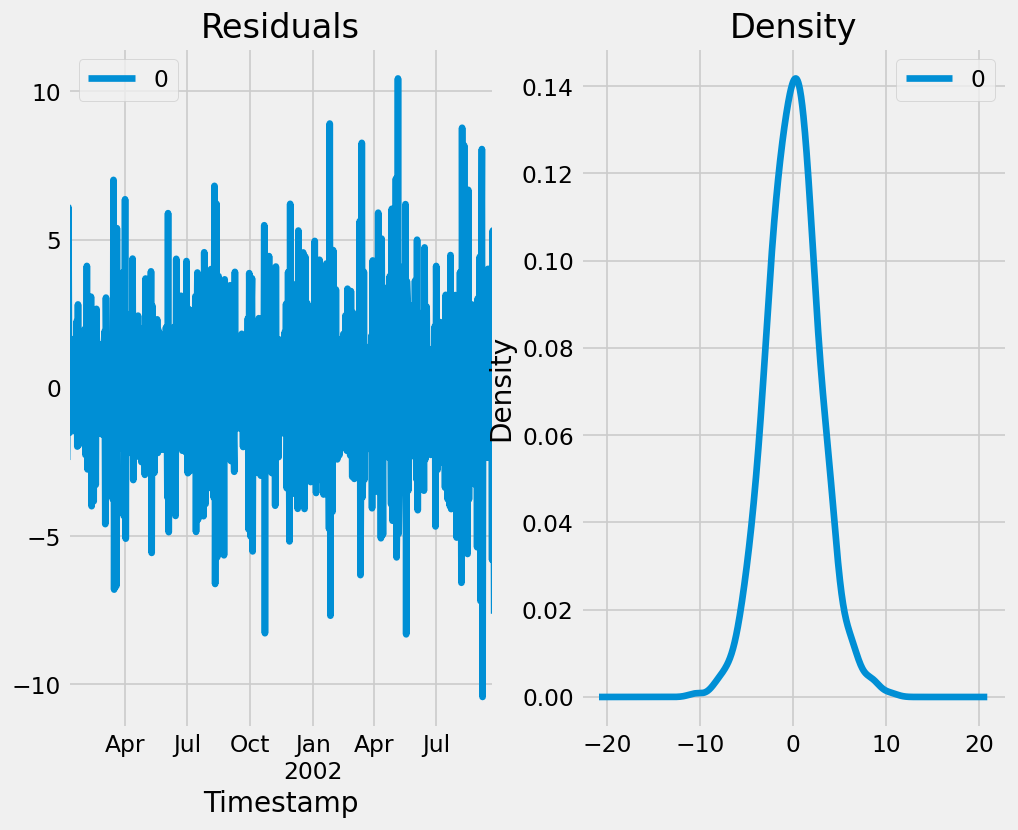

In [412]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

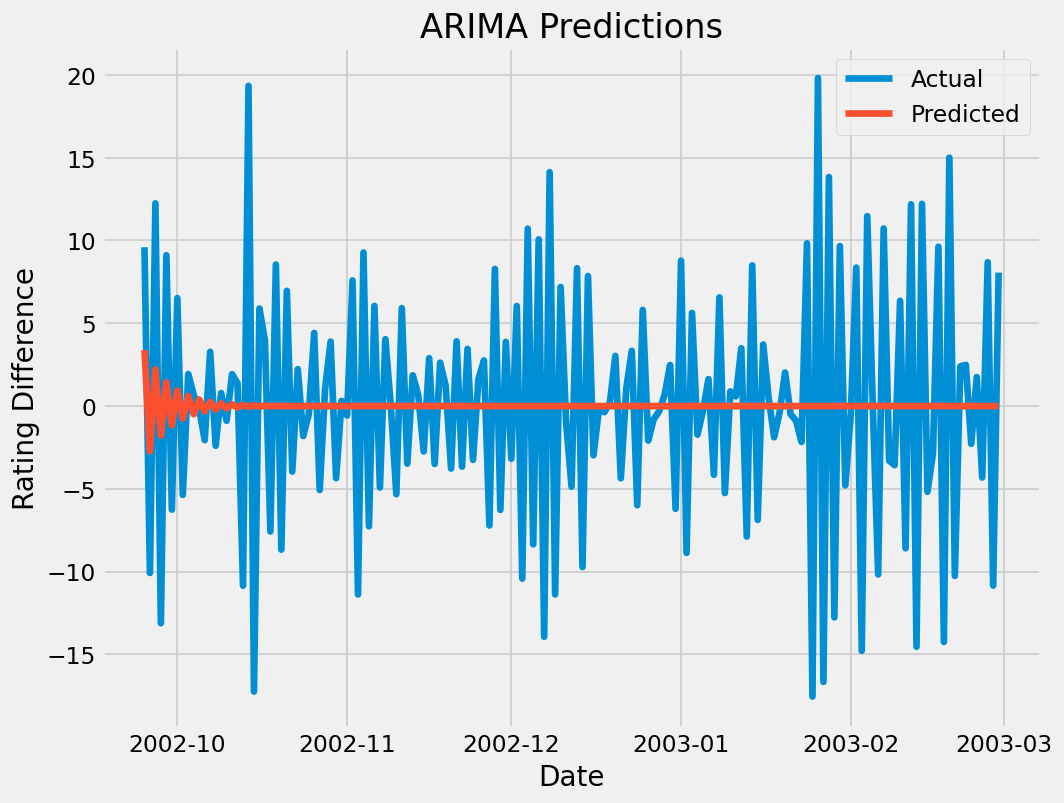

In [413]:
predictions = model_fit.predict(start=train_size, end=len(data_agg)-1)

# Plotting
plt.plot(data_agg.index[train_size:], test_data, label='Actual')
plt.plot(data_agg.index[train_size:], predictions, label='Predicted')
plt.title('ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Rating Difference')
plt.legend()
plt.show()

In [414]:
forecast_steps = 30 
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

In [415]:
predictions = model_fit.predict(start=train_size, end=len(data_agg)-1)
mse = np.mean((predictions - test_data)**2)
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 0.2233171591350649


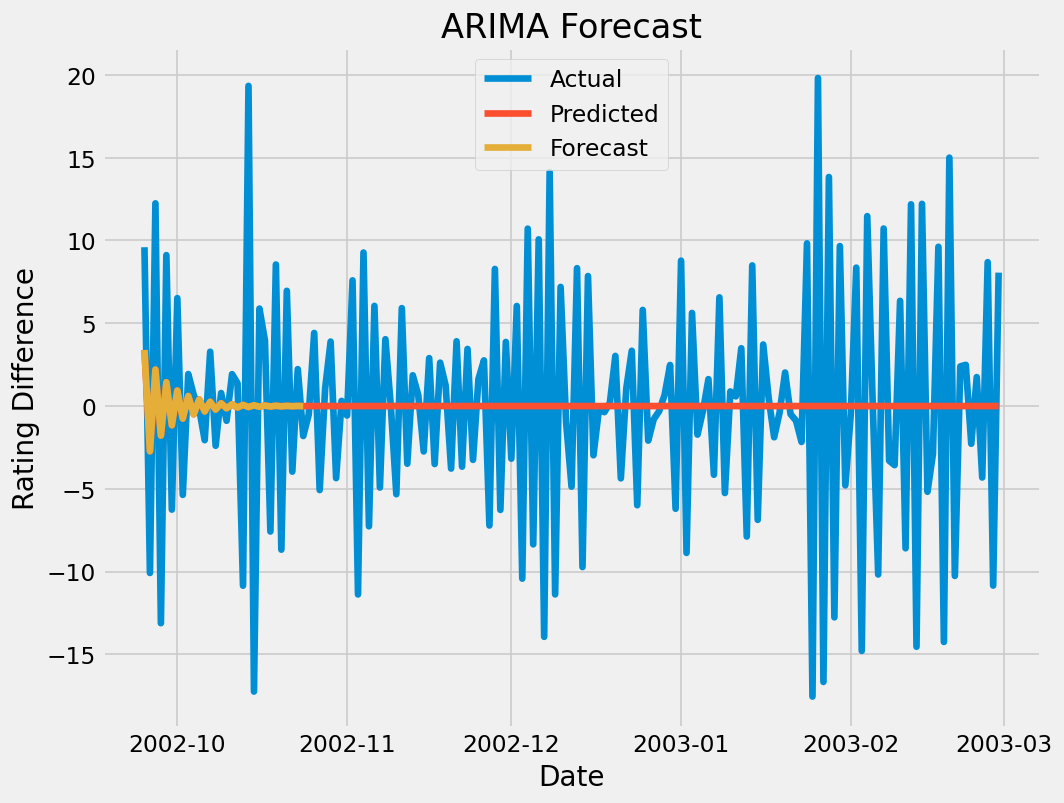

In [416]:
plt.plot(data_agg.index[train_size:], test_data, label='Actual')
plt.plot(data_agg.index[train_size:], predictions, label='Predicted')
plt.plot(pd.date_range(start=data_agg.index[train_size], periods=forecast_steps, freq='D'), forecast_values, label='Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Rating Difference')
plt.legend()
plt.show()

In [417]:
train_size = int(len(data_agg) * 0.7)
train_data = data_agg['rating_diff'][:train_size]
test_data = data_agg['rating_diff'][train_size:]

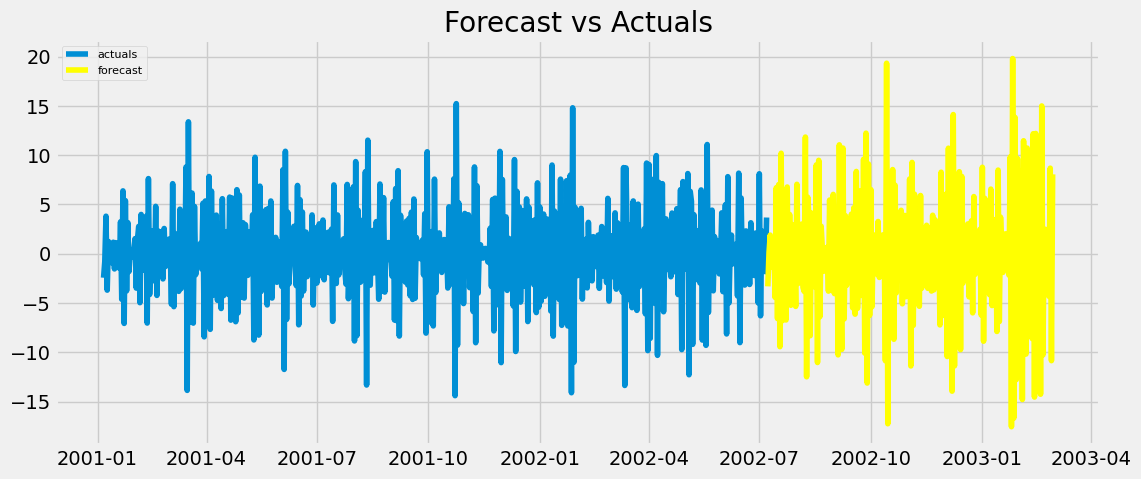

In [418]:
# Build Model
model = ARIMA(train_data, order=(2, 1,1))#(p,d,q)  
fitted = model.fit()

# Forecast
forecast = fitted.get_forecast(steps=75)

# Extract forecasted values and confidence intervals
fc = forecast.predicted_mean
conf = forecast.conf_int()

# Make as pandas series with correct index
fc_series = pd.Series(fc, index=test_data)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_data, label='actuals')
plt.plot(test_data, label='forecast',color ='yellow')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [419]:
# Accuracy metrics
import numpy as np
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) #MAPE
    me = np.mean(forecast - actual)             #ME
    return({'mape':mape, 'me':abs(me)})
forecast_accuracy(fc, test_data)

{'mape': 0.27209674638323533, 'me': 0.01906188136452331}

# PREDICTION

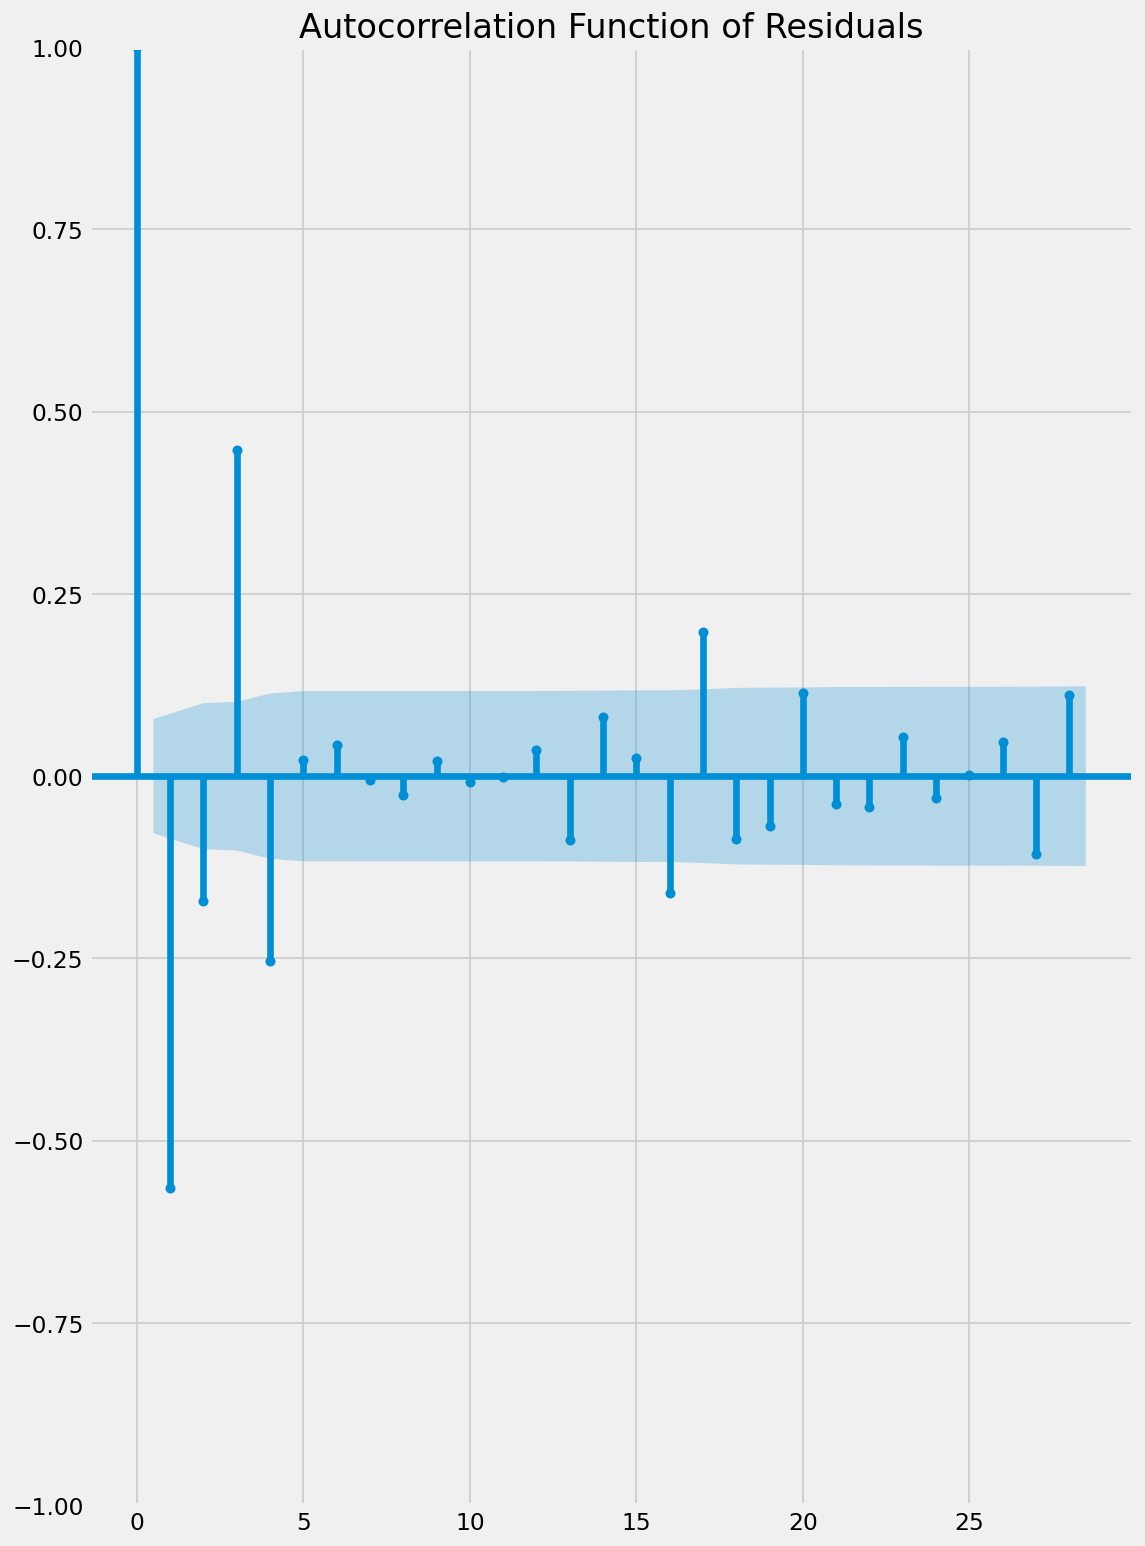

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


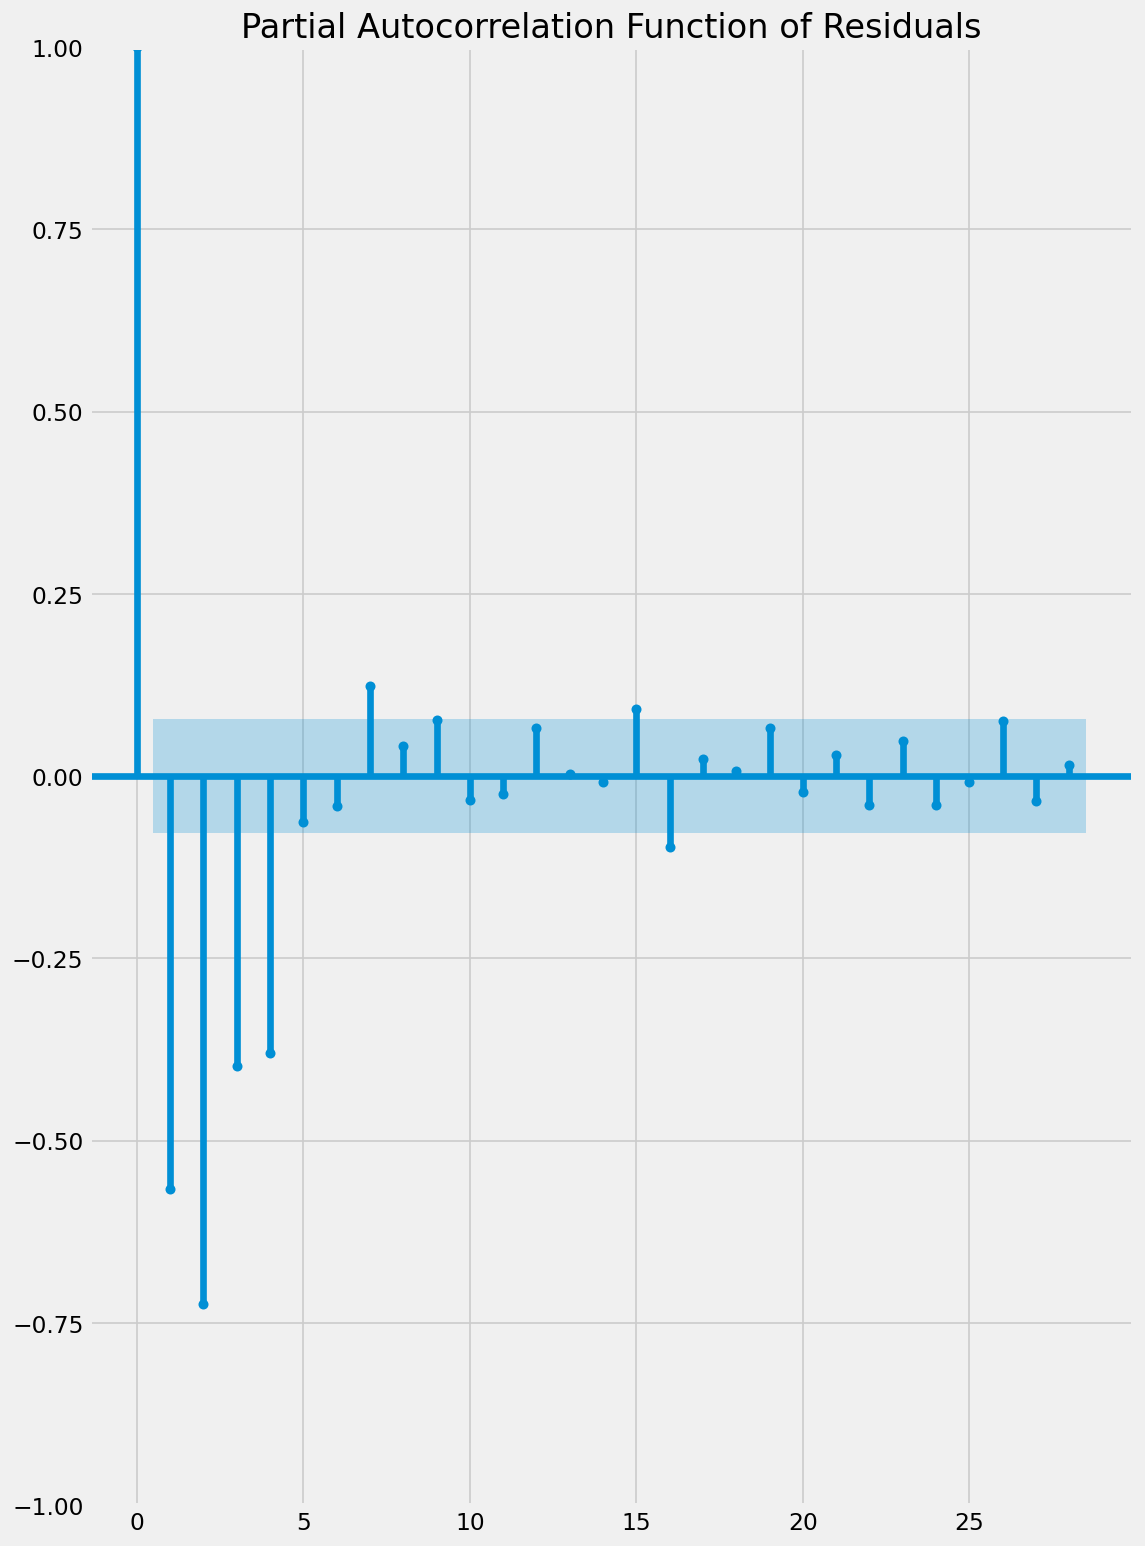

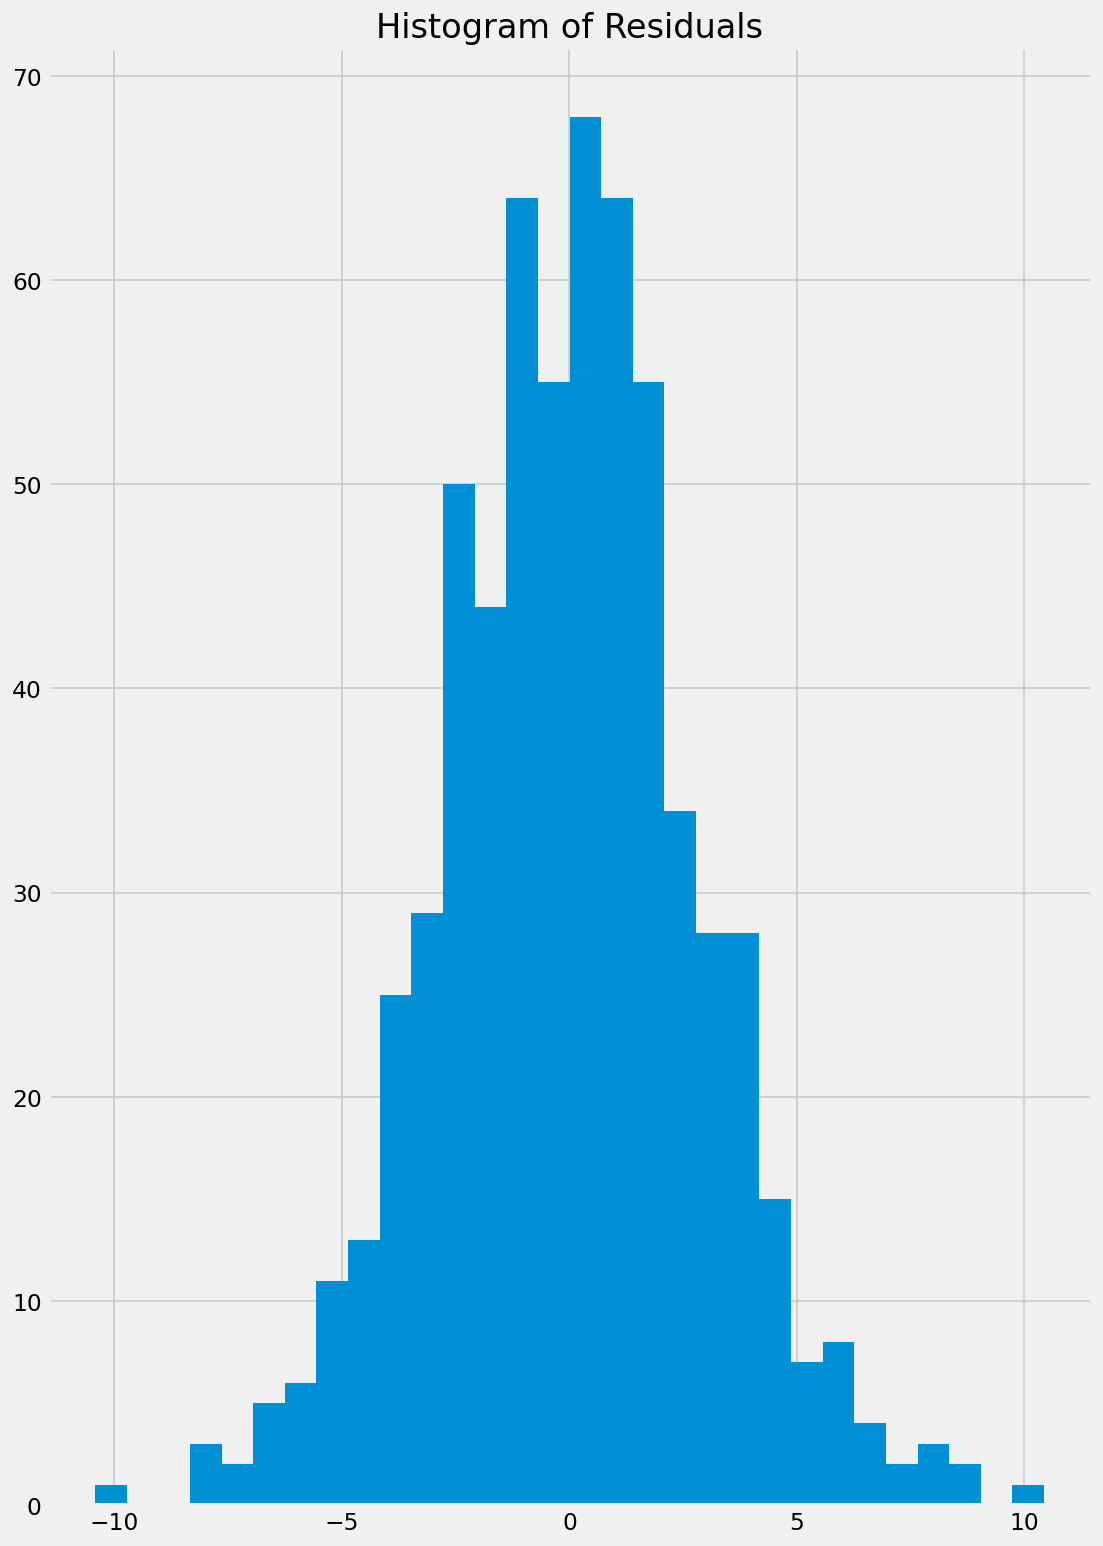

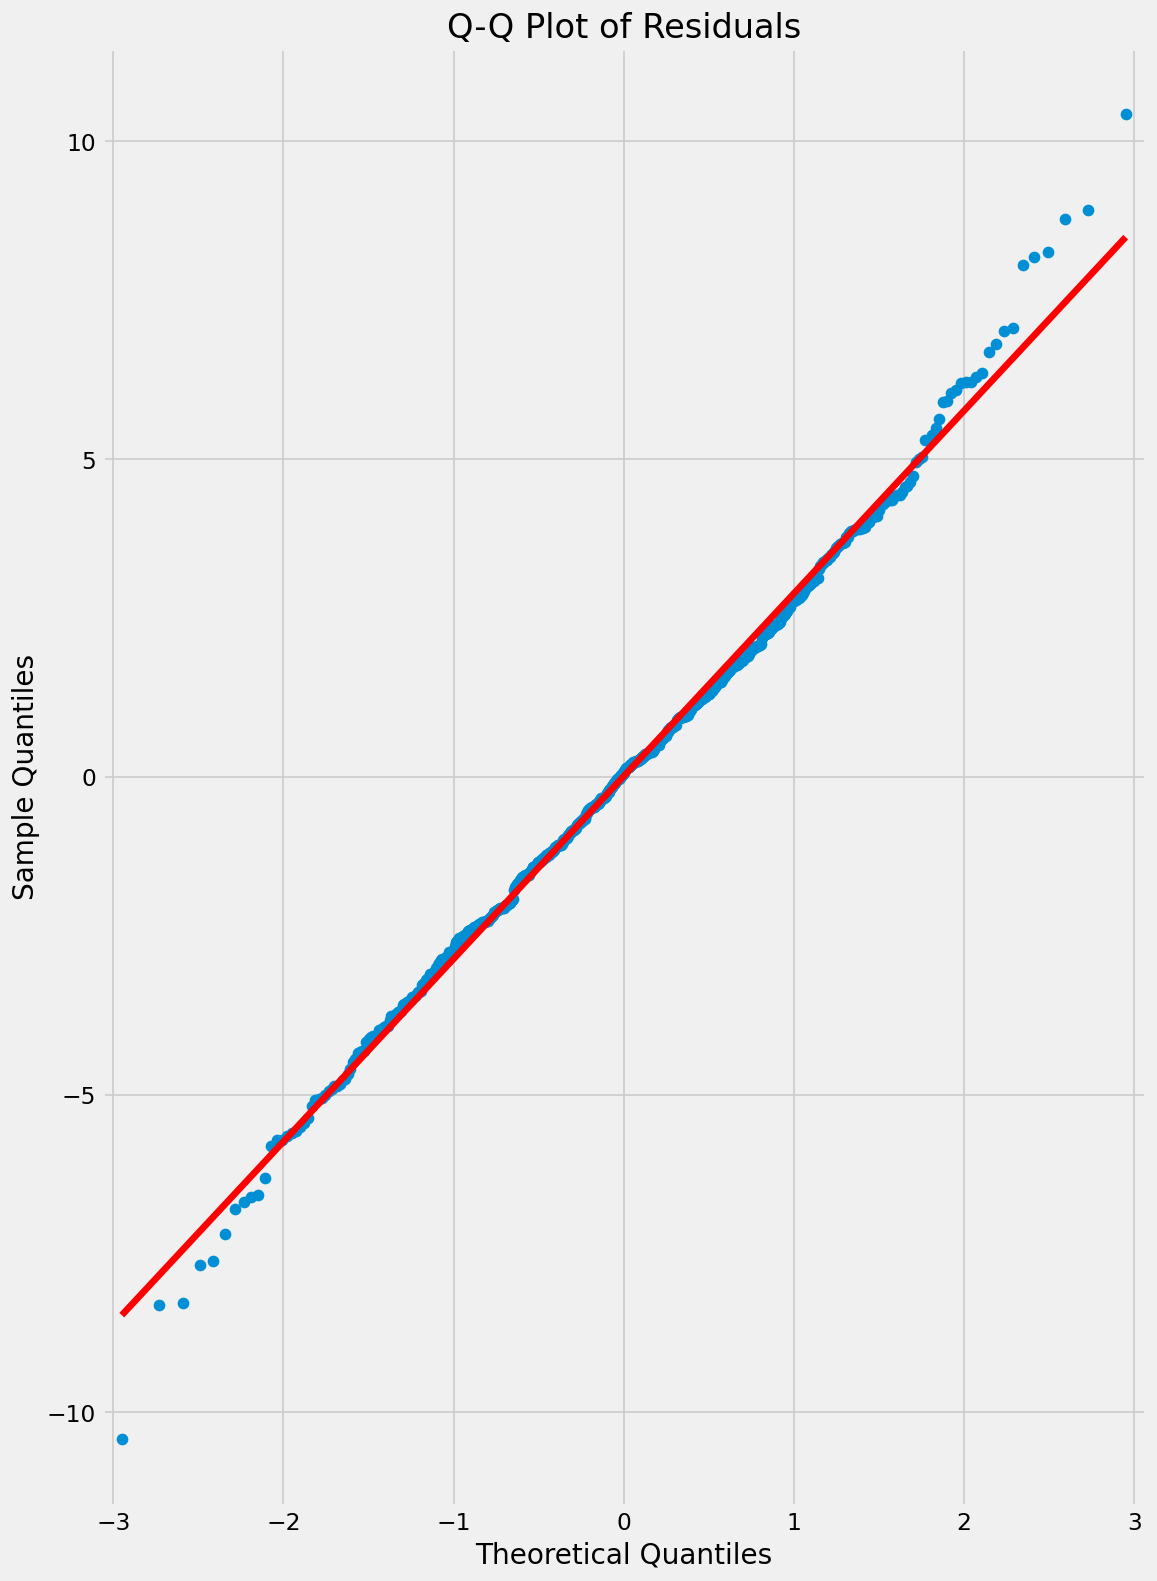

In [420]:
from statsmodels.tsa.api import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict


residuals = model_fit.resid
fig, ax = plt.subplots(figsize=(10, 15))
# Plot ACF of residuals
plot_acf(residuals, ax=ax)
plt.title('Autocorrelation Function of Residuals')
plt.show()

fig, ax = plt.subplots(figsize=(10, 15))
# Plot PACF of residuals
plot_pacf(residuals, ax=ax)
plt.title('Partial Autocorrelation Function of Residuals')
plt.show()

fig, ax = plt.subplots(figsize=(10, 15))
# Plot histogram of residuals
ax.hist(residuals, bins=30)
ax.set_title('Histogram of Residuals')
plt.show()

fig, ax = plt.subplots(figsize=(10, 15))
# Plot Q-Q plot of residuals
qqplot(residuals, line='s', ax=ax)
ax.set_title('Q-Q Plot of Residuals')
plt.show()


In [421]:
data_agg = rts2.resample('D', on='Timestamp').mean().reset_index()
data_agg['rating_diff'] = data_agg['Rating'].diff().diff().diff().diff()
data_agg.dropna(inplace=True)
data_agg.head()

,Timestamp,Rating,rating_diff
4,2001-01-05,3.412595,1.813656
5,2001-01-06,3.825668,-0.620146
6,2001-01-07,3.440433,-1.421394
7,2001-01-08,3.408612,2.390344
8,2001-01-09,3.577869,-1.304060


Epoch 1/3
1/1 [==============================] - 6s 6s/step - loss: 0.2365
Epoch 2/3
1/1 [==============================] - 0s 103ms/step - loss: 0.2021
Epoch 3/3
5/5 [==============================] - 1s 7ms/step
Mean Squared Error: 7.87406580075139e+32


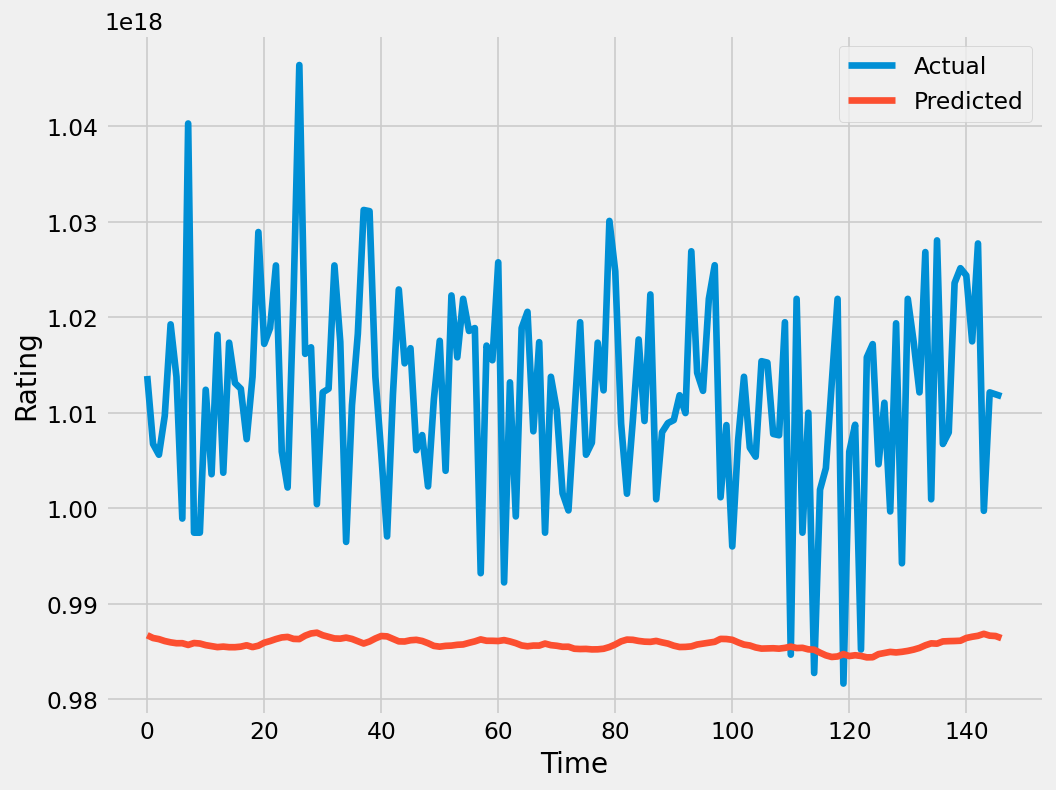

In [422]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming your dataset is stored in a DataFrame called 'dfMovieRatings'
data = data_agg['Rating'].values.reshape(-1, 1)  # Assuming 'Rating' is the target variable
timestamps = data_agg['Timestamp'].values.reshape(-1, 1)  # Assuming 'Timestamp' is the timestamp variable

# Scale the data and timestamps
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_timestamps = scaler.fit_transform(timestamps)

# Split the data into training and testing sets
train_ratio = 0.8  # Percentage of data for training
train_size = int(len(scaled_data) * train_ratio)
train_data = scaled_data[:train_size, :]
train_timestamps = scaled_timestamps[:train_size, :]
test_data = scaled_data[train_size:, :]
test_timestamps = scaled_timestamps[train_size:, :]

# Create input sequences and corresponding labels
def create_sequences(data, timestamps, seq_length):
    X, y, t = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
        t.append(timestamps[i + seq_length])
    return np.array(X), np.array(y), np.array(t)

sequence_length = 10  # Number of previous time steps to consider
X_train, y_train, t_train = create_sequences(train_data, train_timestamps, sequence_length)
X_test, y_test, t_test = create_sequences(test_data, test_timestamps, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=3, batch_size=16384)

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling to get the original values

# Evaluate the model
mse = np.mean((predictions - scaler.inverse_transform(y_test))**2)
print('Mean Squared Error:', mse)

# Plot the predictions and actual values
import matplotlib.pyplot as plt

plt.plot(scaler.inverse_transform(y_test), label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Rating')
plt.show()


In [423]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


   UserID  MovieID    Rating
0       1     1357  4.057235
1       1     3068  4.284560
2       1     1537  4.061349
3       1      647  4.159605
4       1     2194  4.134842


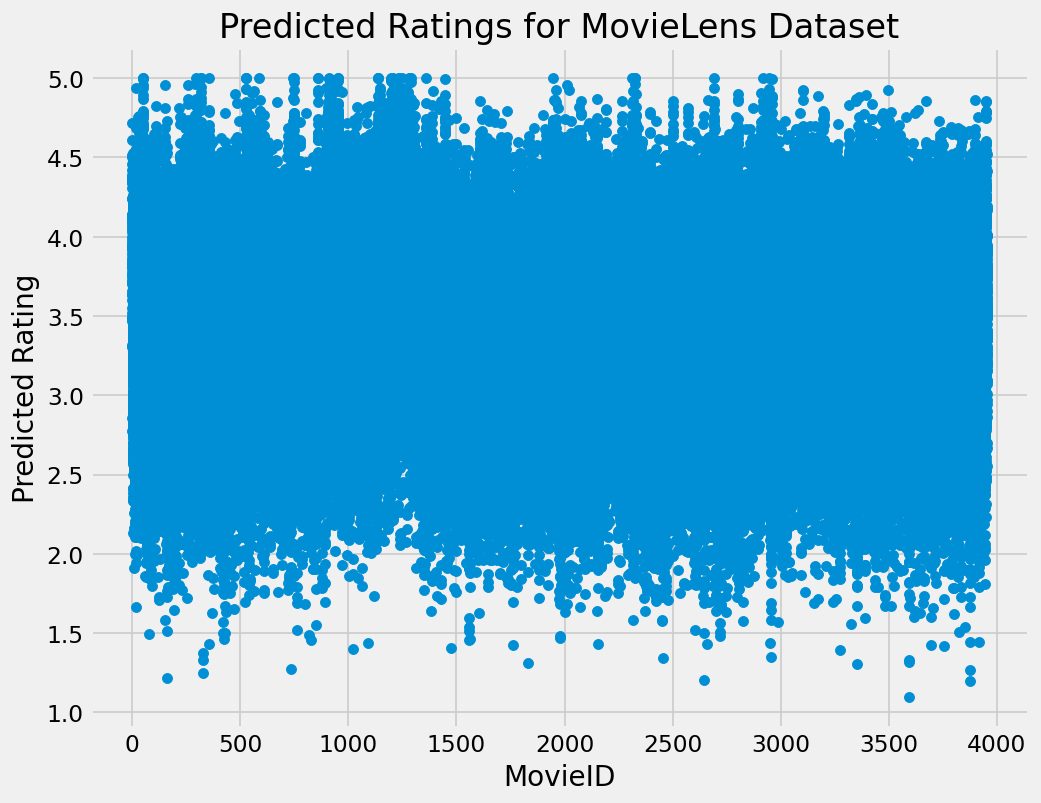

In [424]:
from surprise import Dataset, Reader, SVD
import pandas as pd
import matplotlib.pyplot as plt
# Assuming your dataset is stored in a DataFrame called 'dfMovieRatings'
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(dfMovieRatings[:25000][['UserID', 'MovieID', 'Rating']], reader)

# Build the trainset
trainset = data.build_full_trainset()

# Create the SVD model
svd_model = SVD()

# Train the model
svd_model.fit(trainset)

# Make predictions for all user-movie pairs
testset = trainset.build_anti_testset()
predictions = svd_model.test(testset)

# Extract the predicted ratings
predicted_ratings = pd.DataFrame([[pred.uid, pred.iid, pred.est] for pred in predictions],
                                 columns=['UserID', 'MovieID', 'Rating'])

# Print the predicted ratings
print(predicted_ratings.head())


# Plot the predicted ratings
plt.scatter(predicted_ratings['MovieID'], predicted_ratings['Rating'])
plt.xlabel('MovieID')
plt.ylabel('Predicted Rating')
plt.title('Predicted Ratings for MovieLens Dataset')
plt.show()
